<a href="https://colab.research.google.com/github/estellasouza/SeoulBikeDemand_MachineLearning/blob/main/SeoulBikeDemand_MVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem definition and set up

## Problem description

Rental bikes are available in many urban cities around the world. Their availability can improve mobility issues in highly populated cities.

In order to provide a reliable bike sharing service, it is necessary to understand the demand for bikes over time. In particular, we want to predict the number of bikes required to address the demand over each day, based on dependencies of demand that might exist (e.g., weather, season, time).


## Initial Hypotheses

An initial qualitative analysis would suggest that we should expect to find evidence for the following:


* There is an **positive trend** for rented bikes for the bike sharing market as a whole (https://www.statista.com/statistics/868126/global-bikesharing-market-size/). Therefore, we expect the number of rented bikes required for a steady supply of service to increase.
* There is a **seasonal dependency** on the demand for bikes do to changes in seasonal patterns (e.g., higher during summer and lower during winter), in particular in regions with large seasonal variations (https://weatherspark.com/y/142033/Average-Weather-in-Seoul-South-Korea-Year-Round). Therefore, we expect the demand to modulate (i.e., sin function) over the year.
* There are **weather based daily and hourly fluctuations** on the number of bikes required due to fluctuations on weather (e.g., rain, snow, temperature) over the seasonal trends, e.g., heavy rain, too high temeperatures, too low humidity, heavy snow accumulation, strong winds, etc.
* There is a **hour of the day dependency** in the demand of bikes, e.g., higher demand during rush hour.
* There is a **day of the week and holiday dependencies** in the demand of bikes that could indicate main use of bikes, e.g. transportation, work, leasure, etc.

The main question we want to answer with this model is **how many bikes do we need to supply each hour of each day to address the demand**.
This will be, therefore, a regression problem.



## Data Selection

The data selected provides hourly data of the numbers of bikes rented in Seoul, South Korea, and multiple weather mearurements in the city. This should allow us to explore the different initial hypotheses that were described above.

#### Importing necessary libraries for data explorarion and modeling.

In [1]:
# Configure to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import  LabelEncoder

from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import StratifiedKFold # para preparar os folds da validacao cruzada com estratificacao
from sklearn.model_selection import cross_val_score # para executar a validacao cruzada e retornar scores dos kfolds
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest # para a Seleção Univariada
from sklearn.feature_selection import f_regression# para Seleção Univariada
from sklearn.feature_selection import mutual_info_regression# para Seleção Univariada

from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.metrics import mean_squared_error # métrica de avaliação MSE
from sklearn.metrics import r2_score #

from sklearn.pipeline import Pipeline

# For Adversarial Validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore
from sklearn.metrics import roc_auc_score

#Regression algorithms
from sklearn.linear_model import LinearRegression # algoritmo Regressão Linear
from sklearn.linear_model import Ridge # algoritmo Regularização Ridge
from sklearn.linear_model import Lasso # algoritmo Regularização Lasso
from sklearn.neighbors import KNeighborsRegressor # algoritmo KNN
from sklearn.tree import DecisionTreeRegressor # algoritmo Árvore de Regressão
from sklearn.svm import SVR # algoritmo SVM

#Ensemble libraries
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor


#### Load Data

In [ ]:

# Change data loading later to be from url of github

# url a importar
#url_dados = 'SeoulBikeData.csv'

In [2]:
# Loading data from a file on Google Drive

# Necessary imports
from google.colab import drive

# Mounting the drive
drive.mount("/content/drive", force_remount=True)

# Load the csv dataset
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Sprint1_MachineLearning_Analytics/MVP/SeoulBikeData.csv",encoding='unicode_escape') #encoding necessary due to error message

# Verifying type of object: Pandas
print(type(dataset))

# Printing first 5 lines to verify the headers and data types
dataset.head()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>


Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  01/12/2017                254     0             -5.2           37   
1  01/12/2017                204     1             -5.5           38   
2  01/12/2017                173     2             -6.0           39   
3  01/12/2017                107     3             -6.2           40   
4  01/12/2017                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1                      0.0           0.0            0.0  Winter  No Holiday   
2                      0.0           0.0            0.0  Winter  No Holiday   
3                      0.0           0.0            0.0  Winter  No Holiday   
4                      0.0           0.0            0.0  Winter  No Holiday   

  Functioning Day  
0             Yes  
1             Yes  
2             Yes  
3             Yes  
4             Yes

In [3]:
# Since the data is a time series, verify the end of the data set as well (last 5 entries)
dataset.tail()

Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
8755  30/11/2018               1003    19              4.2           34   
8756  30/11/2018                764    20              3.4           37   
8757  30/11/2018                694    21              2.6           39   
8758  30/11/2018                712    22              2.1           41   
8759  30/11/2018                584    23              1.9           43   

      Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
8755               2.6              1894                      -10.3   
8756               2.3              2000                       -9.9   
8757               0.3              1968                       -9.9   
8758               1.0              1859                       -9.8   
8759               1.3              1909                       -9.3   

      Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons  \
8755                      0.0           0.0            0.0  Autumn   
8756                      0.0           0.0            0.0  Autumn   
8757                      0.0           0.0            0.0  Autumn   
8758                      0.0           0.0            0.0  Autumn   
8759                      0.0           0.0            0.0  Autumn   

         Holiday Functioning Day  
8755  No Holiday             Yes  
8756  No Holiday             Yes  
8757  No Holiday             Yes  
8758  No Holiday             Yes  
8759  No Holiday             Yes

In [4]:
# Checking the number of entries, columns and their indeces, the data types, and any number of null count per column
dataset.info()
dataset.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

(8760, 14)

Attribute information.

*  Date: date of rented bikes (dd/mm/yyyy)
*  Rented Bike Count: number of bikes rented at each hour (integer) - target
*  Hour: hour of the day (integer - 0 to 23)
*  Temperature (°C): temperature in Celsius (float)
*  Humidity (%): humidity measurement in % (integer)
*  Windspeed (m/s): wind speed in meters/second (float)
*  Visibility (10m): visibility within a 10m range (integer)
*  Dew point temperature (°C): temperature of dew point - dependent on temperature and relative humidity (float)
*  Solar radiation (MJ/m2): based on solar exposure in MJ/m2 (float)
*  Rainfall (mm): amount of rain fall in mm (float)
*  Snowfall (cm): amount of snow fall in cm (float)
*  Seasons: Winter, Spring, Summer, Autumn (category)
*  Holiday: if day is considered a holiday - Holiday, No holiday (category)
*  Functional Day: if service is functioning - Yes, No (category)

**Data structure observations:**


* Time series containing 1 year of data (12/01/2017 to 11/30/2018), possibly restricting conclusive results on the seasonality analysis
* No missing values (null values)
* Hourly data
* 14 total columns
 * 2 columns for time stamp (Date & Hour)
 * 11 columns for attributes: 8 numerical weather-based + 3 categorical (Seasons, Holiday, and Functioning Day)
 * Target column: Rented Bike Count



# Data Preparation

#### Initial Data Preparation

During this first part of the data processing, we will focus on cleaning the data set:
  * Ensure "Date" format is clear
  * Rename some of the columns
  * Remove any unnecessary raw data (including instances and features)






In [5]:
# Modifying the format of the date for more clarity on the format
dataset['Date'] = pd.to_datetime(dataset.Date, format='%d/%m/%Y')

# Renaming some columns
dataset.rename(columns={'Rented Bike Count':'Bike_Count',
                        'Temperature(°C)':'Temperature',
                        'Humidity(%)':'Humidity',
                        'Wind speed (m/s)':'Wind',
                        'Visibility (10m)':'Vis',
                        'Dew point temperature(°C)':'Dew_temp',
                        'Solar Radiation (MJ/m2)':'Solar_rad',
                        'Rainfall(mm)':'Rain',
                        'Snowfall (cm)':'Snow',
                        'Functioning Day':'Functioning'
                        },inplace=True)

We want to make sure that no relevant information is provided for the days tagged as "No" under the "Functioning Day" column.

In [6]:
# Series of the number of rented bikes for non-functioning days
dataset_nofunc = dataset.loc[dataset['Functioning']=='No', 'Bike_Count']

# Check if all numbers in "Bike_Count" are zero for the not-functioning days
if (dataset_nofunc==0).all():
  print("Confirmed that the number of bikes rented in non-functioning days is zero. \nThose entries can be removed for further analysis.")
else:
  print("Further understanding needed for attribute 'Functioning Day'")

Confirmed that the number of bikes rented in non-functioning days is zero. 
Those entries can be removed for further analysis.


In [7]:
# Checking share of entries tagged as non-functioning

# Number of non-functioning days
print("Total days of data: ", dataset['Date'].nunique())
print("Non-functioning days: ", dataset.loc[dataset['Functioning']=='No', 'Date'].nunique())
print("Functioning days: ", dataset.loc[dataset['Functioning']=='Yes', 'Date'].nunique())

# Amount of data to be removed
nonFunc_entries = dataset.loc[dataset['Functioning']=='No','Date'].count()/dataset['Date'].count() *100
print("Percent of entries tagged as non-functioning: ", nonFunc_entries, "%")

# Removing unnecessary data entries (entries of non functioning days) and deleting the
dataset_clean = dataset[dataset['Functioning']=='Yes']#.reset_index(drop=True)
dataset_clean = dataset_clean.drop('Functioning', axis=1)

Total days of data:  365
Non-functioning days:  13
Functioning days:  353
Percent of entries tagged as non-functioning:  3.3675799086757987 %


Note that:
* there should be one day that has some entries tagged as non-functioning while others as functioning (353+13 = 366 and not 365)
* this should not have a significant impact in the daily distributions
* the amount of entries to be removed is small: ~3.4%


In [8]:
# dataset_clean: cleaned version of the input data set
dataset_clean.head()

Date  Bike_Count  Hour  Temperature  Humidity  Wind   Vis  Dew_temp  \
0 2017-12-01         254     0         -5.2        37   2.2  2000     -17.6   
1 2017-12-01         204     1         -5.5        38   0.8  2000     -17.6   
2 2017-12-01         173     2         -6.0        39   1.0  2000     -17.7   
3 2017-12-01         107     3         -6.2        40   0.9  2000     -17.6   
4 2017-12-01          78     4         -6.0        36   2.3  2000     -18.6   

   Solar_rad  Rain  Snow Seasons     Holiday  
0        0.0   0.0   0.0  Winter  No Holiday  
1        0.0   0.0   0.0  Winter  No Holiday  
2        0.0   0.0   0.0  Winter  No Holiday  
3        0.0   0.0   0.0  Winter  No Holiday  
4        0.0   0.0   0.0  Winter  No Holiday

#### Exploratory Data Analysis

The goal of this section is to:
  * Learn how data is divided and the numerical vs categorical features provided, and how they change over time
  * Determine what attributes will be useful in understanding the data and what information is still be needed
  * Refine the initial hypotheses presented earlier on

Let's break down the different types of columns that were provided in this data set to better understand how to prepare them for the modeling steps.

###### A. Time series columns: "Date" and "Hour"

* We can refine the information on the date by breaking it down in day, month, and year, as well as keep a tracker on the days since the start of data collection. These numerical features can help on identifying time dependencies.
* It is possible to identify the day of the week based on the date. This could help in identifying weekly trends.


In [107]:
# Add refined time series features to data set

# Break down 'Date' into 'month_year' - to allow correct positioning of monthly data, since dataset starts in December
dataset_clean['month_year'] = dataset_clean['Date'].dt.to_period('M')

# Get Month number and day (numerical)
dataset_clean['month'] = dataset_clean['Date'].dt.month
dataset_clean['day'] = dataset_clean['Date'].dt.day

# Get day of the week (categorical)
dataset_clean['week_day'] = dataset_clean['Date'].dt.day_name()

# Get order of days (starts in first day recorded - 2017/12/01)
dataset_clean['date_order'] = pd.to_datetime(dataset_clean['Date']).apply(lambda Date: Date.toordinal())
dataset_clean['date_order'] = dataset_clean['date_order']-dataset_clean['date_order'].min()

# Check updated dataframe
print("Number of functioning days: ", dataset_clean["date_order"].nunique())
dataset_clean.head()

Number of functioning days:  353


Date  Bike_Count  Hour  Temperature  Humidity  Wind   Vis  Dew_temp  \
0 2017-12-01         254     0         -5.2        37   2.2  2000     -17.6   
1 2017-12-01         204     1         -5.5        38   0.8  2000     -17.6   
2 2017-12-01         173     2         -6.0        39   1.0  2000     -17.7   
3 2017-12-01         107     3         -6.2        40   0.9  2000     -17.6   
4 2017-12-01          78     4         -6.0        36   2.3  2000     -18.6   

   Solar_rad  Rain  Snow Seasons     Holiday month_year  month  day week_day  \
0        0.0   0.0   0.0  Winter  No Holiday    2017-12     12    1   Friday   
1        0.0   0.0   0.0  Winter  No Holiday    2017-12     12    1   Friday   
2        0.0   0.0   0.0  Winter  No Holiday    2017-12     12    1   Friday   
3        0.0   0.0   0.0  Winter  No Holiday    2017-12     12    1   Friday   
4        0.0   0.0   0.0  Winter  No Holiday    2017-12     12    1   Friday   

   date_order  
0           0  
1           0  
2           0  
3           0  
4           0

Mean of date_order: 178.4
Median of date_order: 178.0
Standard deviation of date_order: 104.7
Mean of Hour: 11.5
Median of Hour: 12.0
Standard deviation of Hour: 6.9


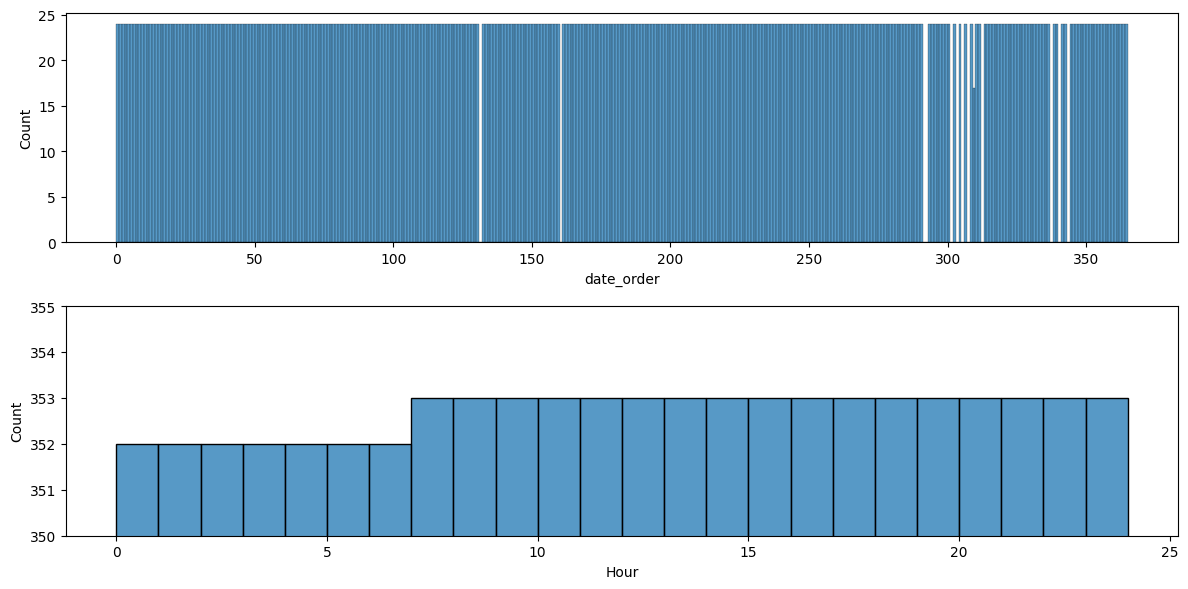

In [ ]:
# Time Series - distribution of entries

# Set up figure
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,6), dpi=100)
#with plt.rc_context({'lines.linewidth': 0.8}):

distribution_features = ['date_order','Hour'] # Variables that will be plotted

for i in range(2):
  bin_range = (dataset_clean[distribution_features[i]].min(),dataset_clean[distribution_features[i]].max()+1) #bin range for the plot
  sns.histplot(data=dataset_clean, x=distribution_features[i], binwidth=1, binrange=bin_range, ax=axs[i], palette="tab10") # Histogram with binwidth of 1 day/hour: 24/353 entries per bin expected
  print("Mean of %s: %0.1f" % (distribution_features[i],dataset_clean[distribution_features[i]].mean()))
  print("Median of %s: %0.1f" % (distribution_features[i],dataset_clean[distribution_features[i]].median()))
  print("Standard deviation of %s: %0.1f" % (distribution_features[i],dataset_clean[distribution_features[i]].std()))

plt.ylim(350,355) #zooming to check missing hours
plt.tight_layout()

As mentioned before, we can see above that one day doesn't have data for the full day (due to some hours being removed as non-functioning). It seems like there was a period of 7 hours that did not function during that day.

Note that there is somewhat of a cluster of non-functioning days close to day 300 that seem to provide a small skew to the distribution. We will later evaluate how the model performs in the test data set close to that region to determine if the model was drastically affected.

###### B. Categorical features: "Seasons", "Holiday", "week_day"

  * Seasons:
    * Since there is one year of data, the dataset spans all four seasons: Winter, Spring, Summer, Autumn.
    * The dependency of the number of rented bikes on the season is likely to be large. However, the month might provided more refined information, since trends might change within one season.
  * Holiday
    * Days are categorized in Holiday or No Holiday - Holidays will likely contitute a very small part of the data.
  * Day of the Week: "Monday", "Tuesday", ..., "Sunday"
    * Enabling easier tracking of daily trends based on demand on different days of the week.

Encoding will be needed during the feature engineering step.



In [ ]:
# Determining percentage of data in categories

# Holiday
print("###### HOLIDAY ######")
print("Share of Holiday/No Holiday in the data set (in %)")
print(dataset_clean.groupby('Holiday')['Date'].count()/dataset_clean['Date'].size *100, "\n")

# Seasons/
print("###### SEASONS ######")
print("Share of Seasons categories in the data set (in %)")
print(dataset_clean.groupby('Seasons')['Date'].count()/dataset_clean['Date'].size *100, "\n")

# Days of the Week
print("###### WEEKDAY ######")
print("Share of Days of the Week categories in the data set (in %)")
print(dataset_clean.groupby('week_day')['Date'].count()/dataset_clean['Date'].size *100, "\n")



###### HOLIDAY ######
Share of Holiday/No Holiday in the data set (in %)
Holiday
Holiday        4.819846
No Holiday    95.180154
Name: Date, dtype: float64 

###### SEASONS ######
Share of Seasons categories in the data set (in %)
Seasons
Autumn    22.882457
Spring    25.516834
Summer    26.083875
Winter    25.516834
Name: Date, dtype: float64 

###### WEEKDAY ######
Share of Days of the Week categories in the data set (in %)
week_day
Friday       14.459539
Monday       14.743060
Saturday     14.376846
Sunday       14.459539
Thursday     14.176019
Tuesday      13.608978
Wednesday    14.176019
Name: Date, dtype: float64 



Given how the data is distributed by categories, we can see that:
* Holidays constitute only ~5% of the data, and therefore we should ensure we have enough samples in the training set to correctly model the demand during Holidays
* Autumn has less data than the other Seasons (~81 days instead of ~90), with a difference of ~10% on the entries due to the removed non-functioning days that were closely clustered during Autumn
* The distribution of days of the week can be considered uniform for this data set


Let's visualize how the number of rented bikes is distributed over time (hourly, daily, monthly) by category:
* Holiday vs No Holiday
* Season  
* Day of the week

**Hourly Dependencies**

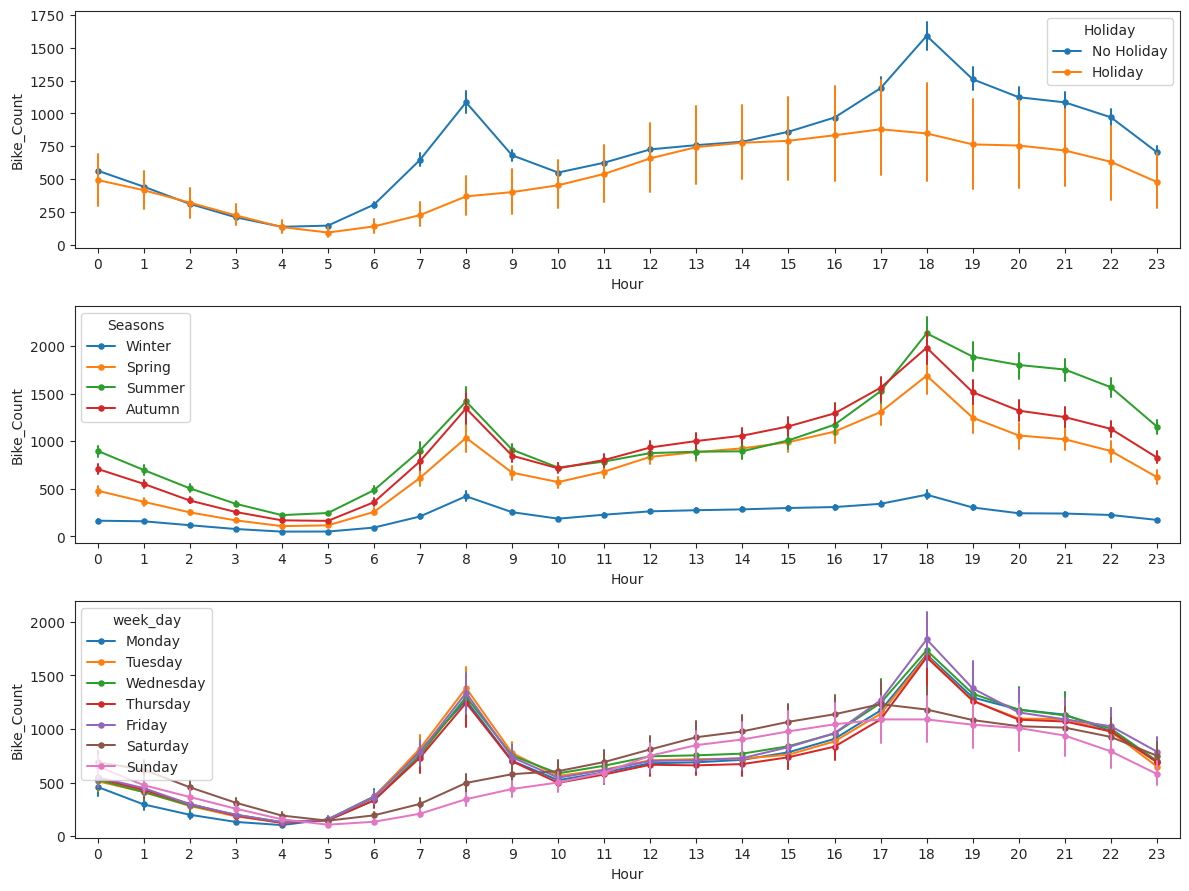

In [ ]:
# Distribution of total number of bikes per hour by category

sns.set_style("ticks")
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(12,9), dpi=100)
with plt.rc_context({'lines.linewidth': 0.8}):
  sns.pointplot(data=dataset_clean, x="Hour", y="Bike_Count", ax=axs[0], hue="Holiday", palette="tab10")
  sns.pointplot(data=dataset_clean, x="Hour", y="Bike_Count", ax=axs[1], hue="Seasons", palette="tab10")
  sns.pointplot(data=dataset_clean, x="Hour", y="Bike_Count", ax=axs[2], hue="week_day", palette="tab10", hue_order=order)
plt.tight_layout()

We can observe different hourly patterns when breaking down the number of rented bikes by the categorical attributes.
* Peaks are observed at 8h and 18h, likely due to transportation to/from work (rush hour). This feature is NOT observed during Holidays and weekends. It is also less pronounced during Winter.
* There is a large suppression on the average number of bikes rented during the Winter across the entire day.
* The curve for Holidays is more similar to the weekend days, however let's confirm that it is not due to all holidays falling on the weekend.
* It might be interesting to break down the same distribution with the different months as the selected category to confirm if they can be used as a proxy for the Seasons.
* Since the distributions of the weekdays are closely matched, we can consider creating a new feature that labels the day as a weekday or a weekend (e.g. 'isWeekday'), in order to decrease the dimensionality when encoding this categorical feature.


In [ ]:
# Checking Holidays distributed by day of the week - if the daily distribution is similar to that of weekends because they fall more often on weekends

df_weekdayHoliday = dataset_clean.groupby('week_day')['Holiday'].value_counts().reset_index()#.agg({'Holiday':'value_counts','week_day':'count'})

df_weekdayHoliday.head(14)

table = pd.pivot_table(df_weekdayHoliday, values='count', index=['week_day'], columns=['Holiday'], aggfunc="sum")

table['% Holiday'] = 100*table['Holiday']/(table['Holiday']+table['No Holiday'])
table['% NoHoliday'] = 100*table['No Holiday']/(table['Holiday']+table['No Holiday'])

table


Holiday    Holiday  No Holiday  % Holiday  % NoHoliday
week_day                                              
Friday          48        1176   3.921569    96.078431
Monday          72        1176   5.769231    94.230769
Saturday        24        1193   1.972062    98.027938
Sunday          72        1152   5.882353    94.117647
Thursday        48        1152   4.000000    96.000000
Tuesday         72        1080   6.250000    93.750000
Wednesday       72        1128   6.000000    94.000000

As seen above, most of the holidays do not follow on weekends. Therefore, the shape we observed above (of the Bike_Count over the hours of the day during Holidays), is not due to most Holidays falling on the weekend. It is likely due to customer behavior being intrinsically similar in Holidays and weekends.

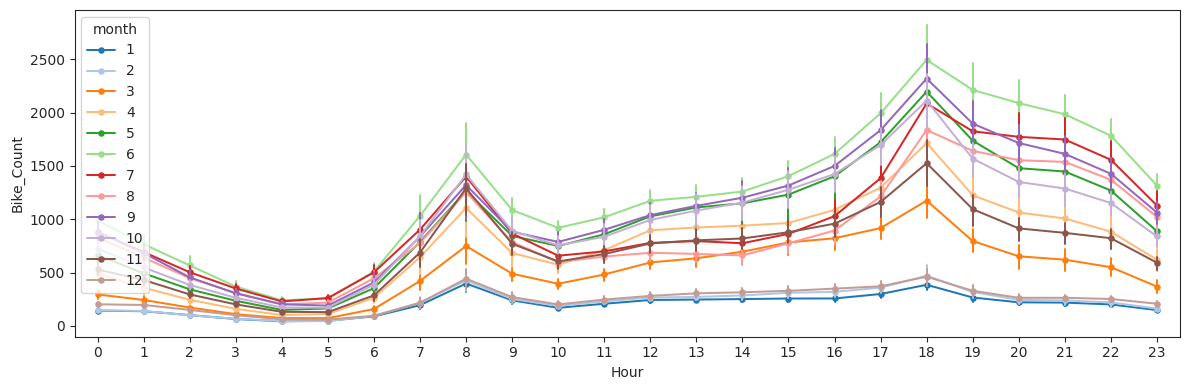

In [ ]:
# Distribution of total number of bikes per hour by month as proxy for season

sns.set_style("ticks")

fig = plt.figure(figsize=(12,4))
with plt.rc_context({'lines.linewidth': 0.8}):
  sns.pointplot(data=dataset_clean, x="Hour", y="Bike_Count", hue="month", palette="tab20")
plt.tight_layout()

We can see that there is a more gradual change on the shape of the hourly distribution, providing more refinement in the assessment of the seasonal changes. Therefore, the 'Seasons' feature will not be used in training.

**Daily Dependencies**

Considering it over the hourly averages of 'Bike_Count' in the days in a week, in a month, and in a year of data

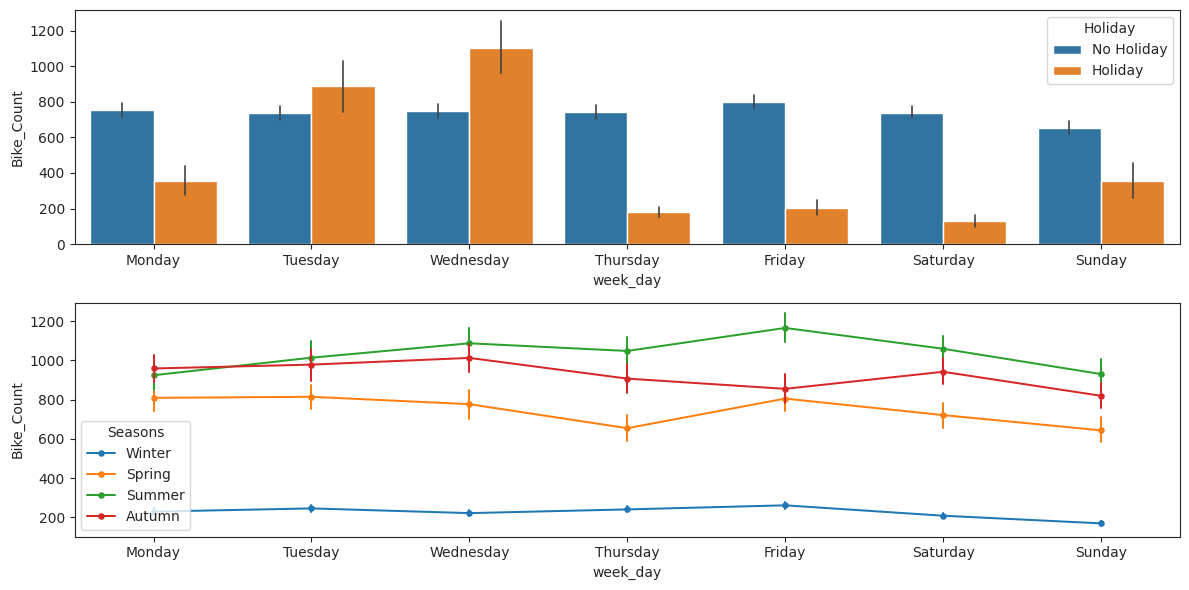

In [ ]:
# Week days
# Hourly average of bikes rented in days of the week

# The order of days of the week that we want to display in the plot
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,6), dpi=100)
with plt.rc_context({'lines.linewidth': 0.8}): #line thickness
  sns.barplot(data=dataset_clean, x="week_day", y="Bike_Count", ax=axs[0], hue="Holiday", palette="tab10", order=order)
  sns.pointplot(data=dataset_clean, x="week_day", y="Bike_Count", ax=axs[1], hue="Seasons", palette="tab10", order=order)
plt.tight_layout()

From the plot above we can conclude that the number of bikes rented is relatively stable over weeks of same season.

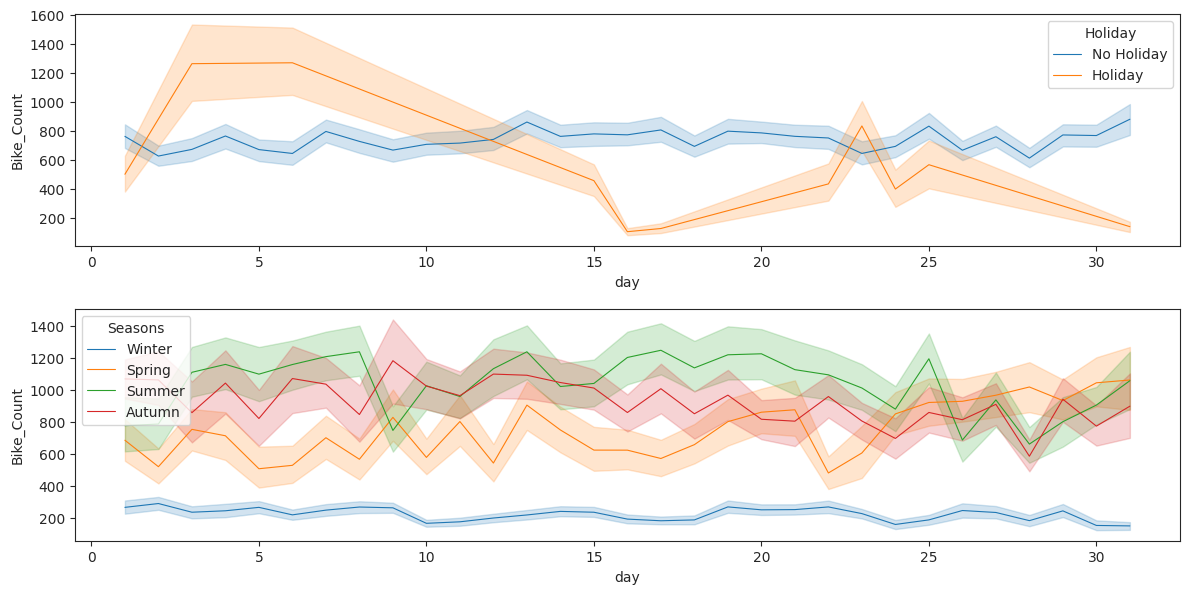

In [ ]:
# Monthly
# Hourly average of bikes rented in days of the month

fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,6), dpi=100)
with plt.rc_context({'lines.linewidth': 0.8}): #line thickness
  sns.lineplot(data=dataset_clean, x="day", y="Bike_Count", ax=axs[0], hue="Holiday", palette="tab10")
  sns.lineplot(data=dataset_clean, x="day", y="Bike_Count", ax=axs[1], hue="Seasons", palette="tab10")
plt.tight_layout()

No clear dependency on the day of the month.

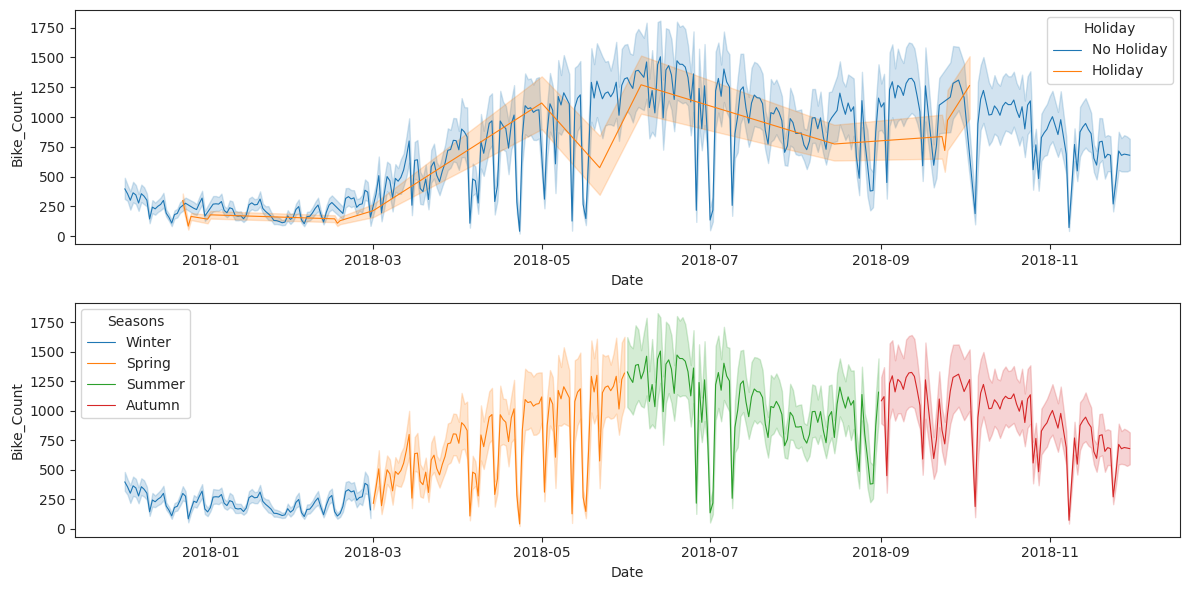

In [ ]:
# Yearly
# Hourly average of bikes rented in days of the year of data

fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,6), dpi=100)
with plt.rc_context({'lines.linewidth': 0.8}):
  ax0 = sns.lineplot(data=dataset_clean, x="Date", y="Bike_Count", ax=axs[0], hue="Holiday", palette="tab10")
  ax1 = sns.lineplot(data=dataset_clean, x="Date", y="Bike_Count", ax=axs[1], hue="Seasons", palette="tab10")

plt.tight_layout()

Note that:
* There are clear seasonal trends, but with strong fluctuations throughout the year, indicating need for refinement with weather parameters
* The "Seasons" feature is just based on the month, and therefore, it will not be used (as already suggested previously), since the other weather parameters might provide the additional needed information to explain the seasonal trends.

**Monthly Dependencies**

Hourly average of bikes in rented the months in the year of data. This visualization should enable us to see the seasonal trends more clearly (less fluctuations due to daily weather patterns), given that the months do not have more than one season.

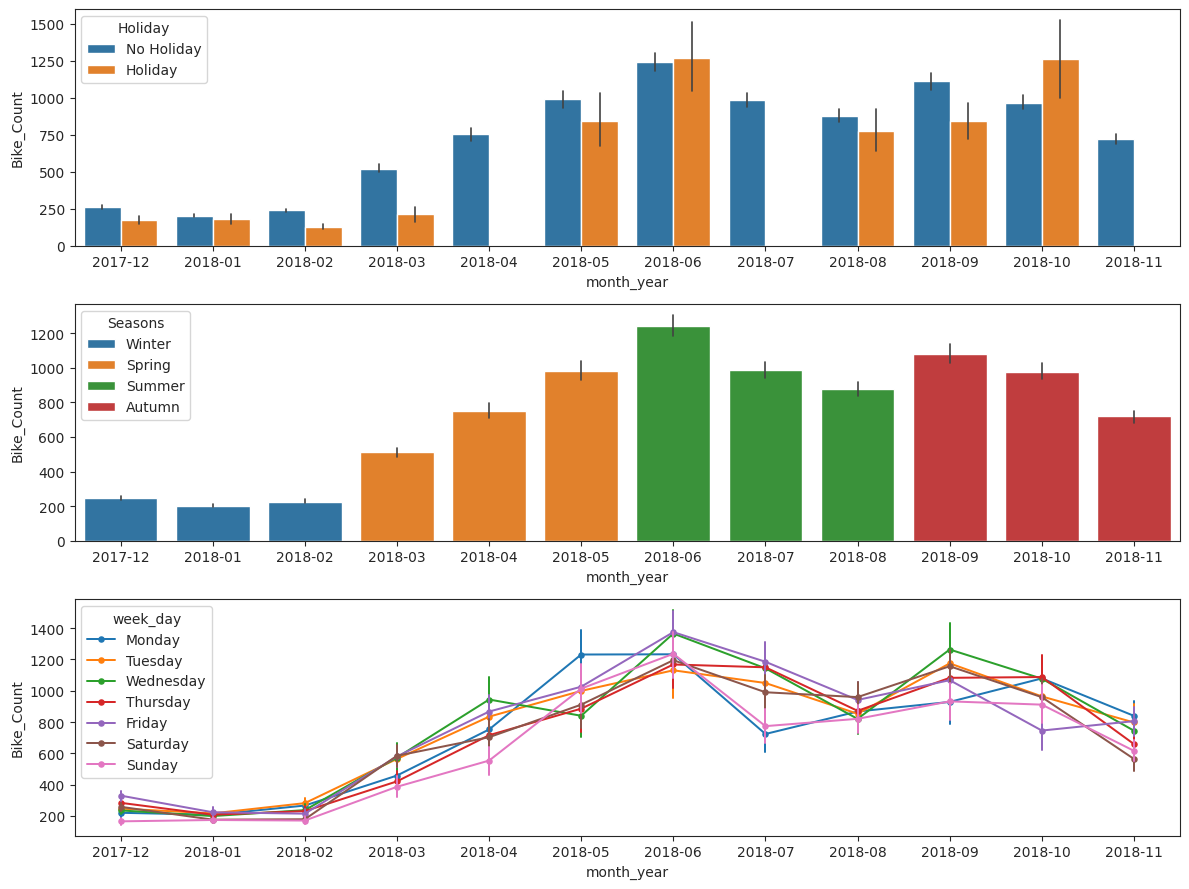

In [ ]:
# Hourly average of bikes rented per month - for the different categorical attributes

order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(12,9), dpi=100)
with plt.rc_context({'lines.linewidth': 0.8}):
  ax0 = sns.barplot(data=dataset_clean, x="month_year", y="Bike_Count", ax=axs[0], hue="Holiday", palette="tab10")
  ax1 = sns.barplot(data=dataset_clean, x="month_year", y="Bike_Count", ax=axs[1], hue="Seasons", palette="tab10")
  ax2 = sns.pointplot(data=dataset_clean, x="month_year", y="Bike_Count", ax=axs[2], hue="week_day", palette="tab10", hue_order=order)

plt.tight_layout()

Note that the hourly average of 'Bike_Count' in each month per day of the week does not vary much. This likely indicates that the day of the week is more important for the hourly bike prediction rather than for the expected daily average.

###### C. Numerical features: weather related measurements

The numerical features we have is this data set are provenient of weather-based measurements. We want to understand which additional preprocessing is needed for these features and which ones should be selected/changed (which ones are relevant).

**Weather Analysis**

Understanding how some weather features can impact number of bikes rented.

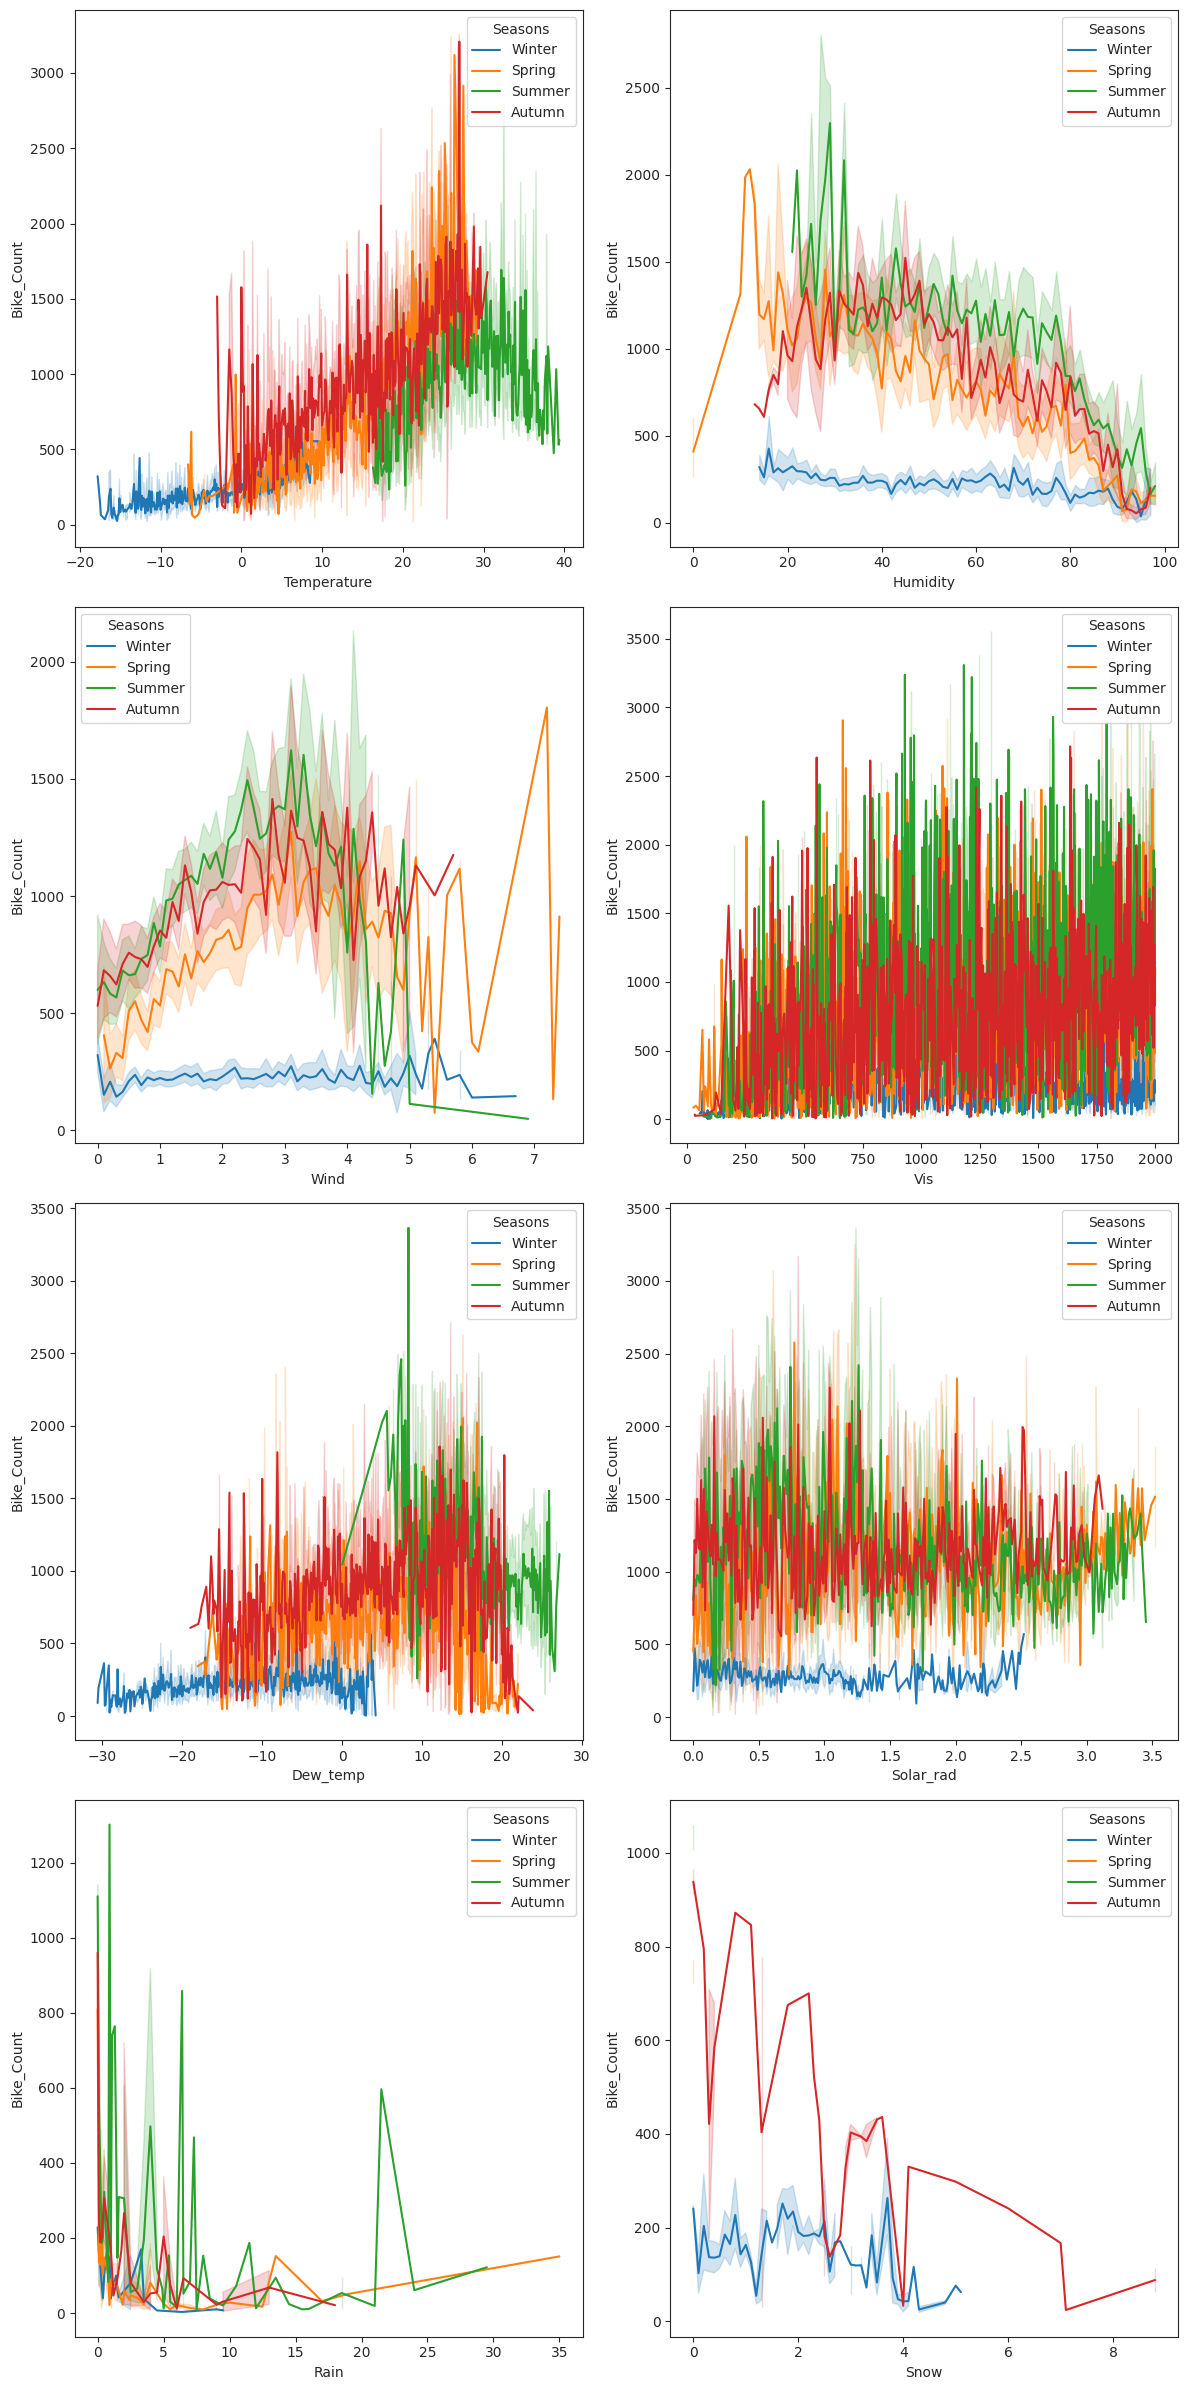

In [ ]:
# 8 numerical features (weather-based)
numerical_features = ['Temperature','Humidity','Wind','Vis','Dew_temp','Solar_rad','Rain','Snow']

fig, axs = plt.subplots(nrows=4,ncols=2,figsize=(12,24), dpi=100)
for i, feat_element in enumerate(numerical_features):
  plt.subplot(4,2,i+1)
  sns.lineplot(data=dataset_clean, x=feat_element, y='Bike_Count', hue='Seasons', palette="tab10")

plt.tight_layout()

First, let's compare the weather-based measurements to the number of rented bikes over the timeline of the data set.

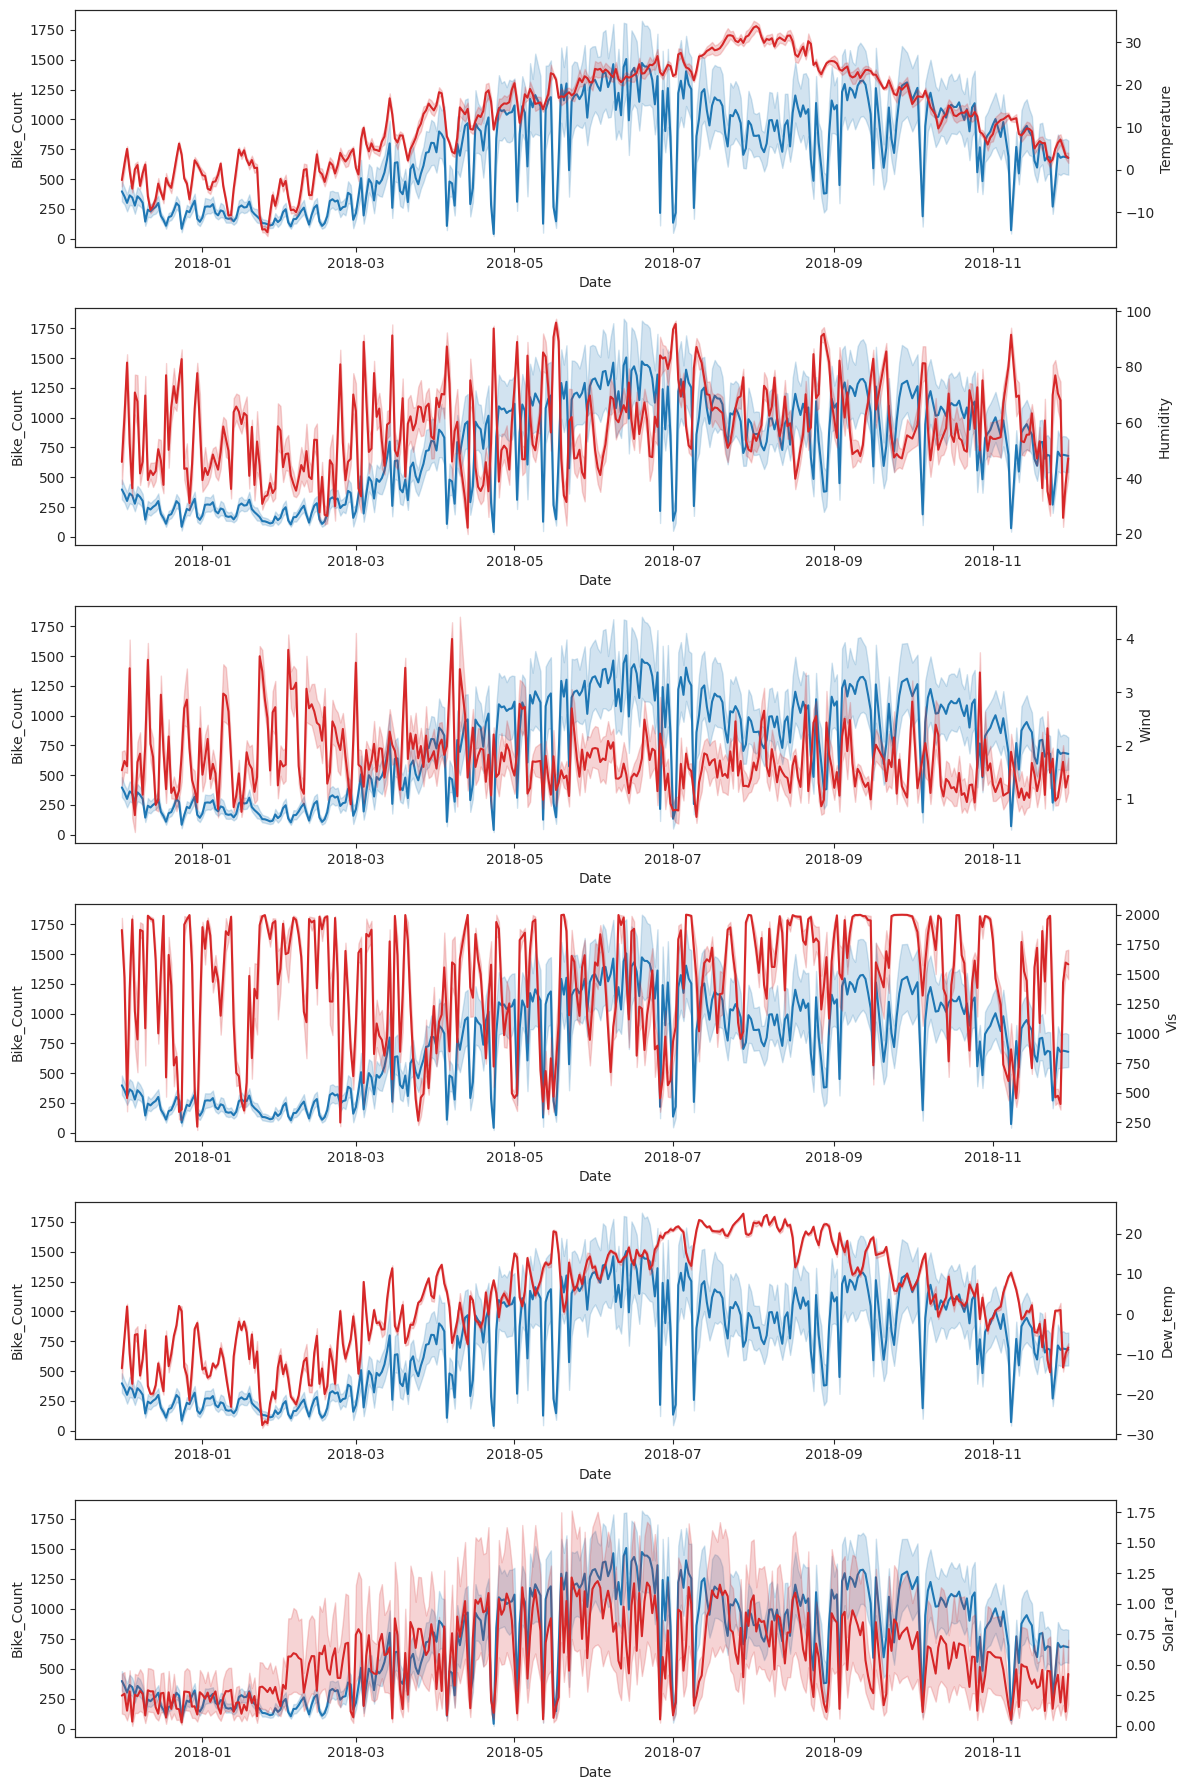

In [ ]:
# Looking at the comparison of bike rentals to the numerical attributes over time (except Rain & Snow - see more below)
numerical_features = ['Temperature','Humidity','Wind','Vis','Dew_temp','Solar_rad']

fig, axs = plt.subplots(nrows=6,ncols=1,figsize=(12,18), dpi=100)

for i in range(6):
  ax0 = sns.lineplot(data=dataset_clean, x='Date', y='Bike_Count', ax=axs[i], color="tab:blue")
  sns.lineplot(data=dataset_clean, x='Date', y=numerical_features[i], ax=ax0.axes.twinx(), color="tab:red")

plt.tight_layout()

Based on the comparisons above, we can see that:
* The distribution of bikes rented over time follows a similar macro trend to that of the **```Temperature```**  and the **```Dew point temperature```**.
* Since the dew point temperature is based on a calculation of temperature and humidity, and as shown above, is *highly correlated to the temperature curve*, we can disconsider that attribute in the modeling (remove ```Dew point temperature```).
* The Solar Radiation overarching trend seems to peak around the end of June (Northern Hemisphere summer solstice), which indicates that the daily average is driven mostly by the number of hours between sun rise and sun down. Daily variations likely due to daily weather patterns (e.g., cloud coverage).

Rain and snow indicators might impact demand for entire days instead of only at the hour of measurement. For example: people might not rent bikes based on weather forecasts if it indicates that it will rain/snow, or snow/rain accumulation might be large from previous hours and impact future rentals.

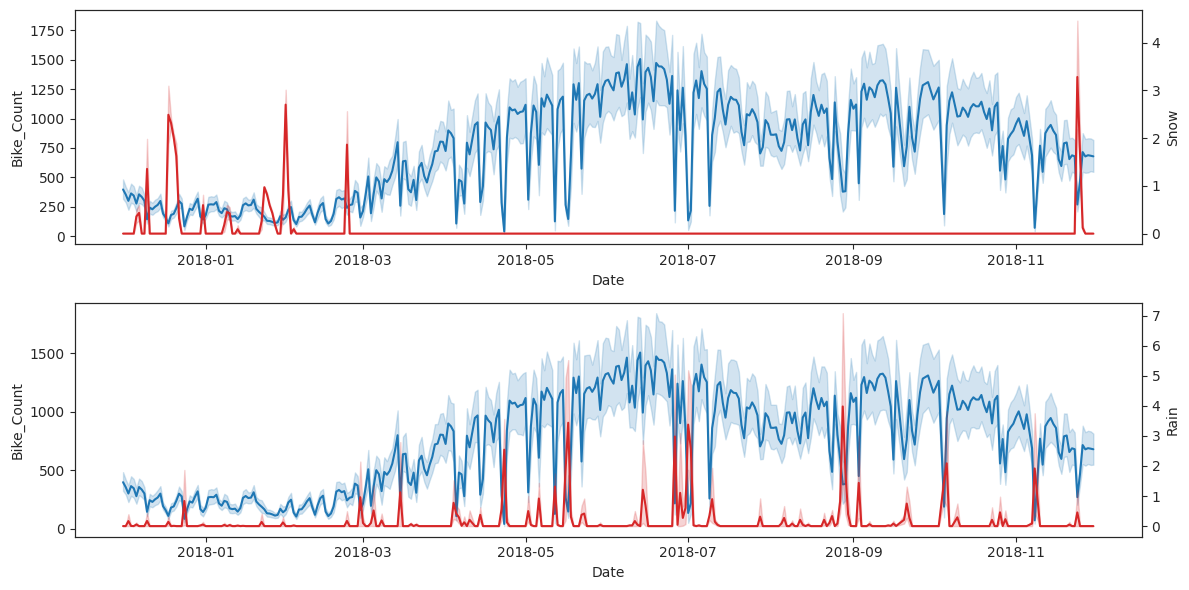

In [ ]:
# Rain and Snow
# Looking at the comparison of bike rentals to the Rain and Snow attributes over time

fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,6), dpi=100)

ax0 = sns.lineplot(data=dataset_clean, x='Date', y='Bike_Count', ax=axs[0], color="tab:blue")
ax1 = sns.lineplot(data=dataset_clean, x='Date', y='Bike_Count', ax=axs[1], color="tab:blue")
sns.lineplot(data=dataset_clean, x='Date', y='Snow', ax=ax0.axes.twinx(), color="tab:red")
sns.lineplot(data=dataset_clean, x='Date', y='Rain', ax=ax1.axes.twinx(), color="tab:red")

plt.tight_layout()

As we can see above, even small amounts of rain and snow can impact the number of bikes rented, possibly due to what is predicted for that day. Therefore, we will **add to the dataset two categorical attributes**: "Rain_day" and "Snow_day". They will have value 0 if there is no rain/snow that day, and 1 if there is.

**Conclusion of exploratory data analysis:**

**1. Observations**
* There is a cluster of non-functioning days close to day 300 that seem to provide a small skew to the distribution, requiring further evaluation of possible impact in the training later.
* Holidays constitute only ~5% of the data, and therefore we should ensure we have enough samples in the training set to correctly model the demand during Holidays.
* There are peaks of rented bikes at hours 8h and 18h, likely due to transportation to/from work (rush hour), as they are NOT observed during Holidays and weekends.
* There is a large suppression on the average number of bikes rented during the Winter across the entire day (less pronounced features in the distribution).
* The hourly distribution of bikes rented during Holidays is more similar to the weekend ones, even though holidays are well distributed through days of the week.
* Months can be used as proxy for seasons, since the same three months will always be part of the same season, and the month variable will also provide a more gradual change in the distribution of rented bikes over the days.
* Since the distributions of the weekdays are closely matched, we will add a new categorical feature ('isWeekday') to check if the day is a weekday (1) or weekend (0) instead of applying label encoding to the 'week_day' variable and increasing the dimensionality substantially.
* The distribution of bikes rented over time follows a similar macro trend to that of the temperature and the dew point temperature (which is closely related to temperature and humidity, and therefore will be removed).
* The Solar Radiation overarching trend seems to peak around the end of June (Northern Hemisphere summer solstice), which indicates that the daily average is driven mostly by the number of hours between sun rise and sun down. Daily variations likely due to daily weather patterns (e.g., cloud coverage).
* New 'Rain_day' and 'Snow_day' binary features will be tested as proxy for 'Rain' and 'Snow', since the initial exploratory analysis suggests that the impact of rain and snow in number of bikes rented might not be linearly dependent on the amount of rain/snow, but rather on if there was rain/snow or not. Depending on performance, we might need to apply further analysis to evaluate correctly if there is a threshold that needs to be applied.

**2. Updated Hypotheses**

* Given that we have only one year of data, is unclear from the dataset alone if there is really a positive trend in the data due simply to the overall market size growth (https://www.statista.com/statistics/868126/global-bikesharing-market-size/).
* There is a clear seasonal dependency on the demand for bikes do to changes in seasonal patterns, including a correlation to temperature (demand decreases with too high or too low temperatures), with non-linear relationships to time (modulates over the year and day) and weather features.
* There are weather based daily and hourly fluctuations on the number of bikes required due to fluctuations on weather (e.g., rain, snow, temperature) over the seasonal trends, e.g., heavy rain, too high temeperatures, too low humidity, heavy snow accumulation, strong winds, etc.
* There is a hour of the day dependency in the demand of bikes, e.g., higher demand during rush hour during weekdays and non-holidays

Based on these observations, the problem could potentially be broken down into two: a macro prediction of daily average of hourly bike demand, and a micro hourly prediction of fluctuations to the daily average. We will, therefore, break down the modeling section in two to test and compare the performance of using training the data set once vs training it in two steps.

#### Feature Engineering

In [9]:
# Add refined time series features to data set

# Make working copy of clean dataset
df_processing = dataset_clean.copy()

# Break down 'Date' into 'month_year' - to allow correct positioning of monthly data, since dataset starts in December
#df_processing['month_year'] = dataset_clean['Date'].dt.to_period('M')

# Get year, month number, and day (numerical)
df_processing['year'] = dataset_clean['Date'].dt.year
df_processing['month'] = dataset_clean['Date'].dt.month
df_processing['day'] = dataset_clean['Date'].dt.day

# Get day of the week (categorical)
df_processing['week_day'] = dataset_clean['Date'].dt.day_name()

# Get order of days (starts in first day recorded - 2017/12/01)
df_processing['date_order'] = pd.to_datetime(dataset_clean['Date']).apply(lambda Date: Date.toordinal())
df_processing['date_order'] = df_processing['date_order']-df_processing['date_order'].min()

# Remove 'Date' columns, since we now have all the information broken down
df_processing = df_processing.drop('Date', axis=1)

# Check updated dataframe
print("Number of functioning days: ", df_processing["date_order"].nunique())
df_processing.head()

Number of functioning days:  353


Bike_Count  Hour  Temperature  Humidity  Wind   Vis  Dew_temp  Solar_rad  \
0         254     0         -5.2        37   2.2  2000     -17.6        0.0   
1         204     1         -5.5        38   0.8  2000     -17.6        0.0   
2         173     2         -6.0        39   1.0  2000     -17.7        0.0   
3         107     3         -6.2        40   0.9  2000     -17.6        0.0   
4          78     4         -6.0        36   2.3  2000     -18.6        0.0   

   Rain  Snow Seasons     Holiday  year  month  day week_day  date_order  
0   0.0   0.0  Winter  No Holiday  2017     12    1   Friday           0  
1   0.0   0.0  Winter  No Holiday  2017     12    1   Friday           0  
2   0.0   0.0  Winter  No Holiday  2017     12    1   Friday           0  
3   0.0   0.0  Winter  No Holiday  2017     12    1   Friday           0  
4   0.0   0.0  Winter  No Holiday  2017     12    1   Friday           0

In [10]:
# Checking the current dataset
df_processing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8465 entries, 0 to 8759
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Bike_Count   8465 non-null   int64  
 1   Hour         8465 non-null   int64  
 2   Temperature  8465 non-null   float64
 3   Humidity     8465 non-null   int64  
 4   Wind         8465 non-null   float64
 5   Vis          8465 non-null   int64  
 6   Dew_temp     8465 non-null   float64
 7   Solar_rad    8465 non-null   float64
 8   Rain         8465 non-null   float64
 9   Snow         8465 non-null   float64
 10  Seasons      8465 non-null   object 
 11  Holiday      8465 non-null   object 
 12  year         8465 non-null   int32  
 13  month        8465 non-null   int32  
 14  day          8465 non-null   int32  
 15  week_day     8465 non-null   object 
 16  date_order   8465 non-null   int64  
dtypes: float64(6), int32(3), int64(5), object(3)
memory usage: 1.1+ MB


Note that some feature engineering was already applied during the Exploratory Data Analysis section (time variables).

Based on the exploratory data analysis, we can see that some modifications of features will be necessary, such as:

* Addition of other needed variables
* Encoding

Once that is done, we can apply the Feature Selection.

**Adding new categorical features**

Based on the observations done in the exploratory data analysis, we concluded that two new attributes were necessary: "Rain_day" and "Snow_day". Both these features will be binary (days with any Rain/Snow = 1, days with no rain/snow = 0). Note that it it possible to change the threshold of rain/snow needed for the day to be tagged. We can revisit that depending on the importance of these attributes later on. For now, let's continue by tagging days with any rain and snow, given that the previous analysis seems to show that the impact might not be proportional to the amount of rain/snow.

In [11]:
# Snow/Rain Days

# To understand if there is a daily impact (instead of only hourly impact) of rain and snow in the number of bikes rented,
# we can create binary categorical variables that will indicate if there was rain/snow in that day.

# New dataframes with the grouped data by "Date" - extract the sum per day
df_rain = df_processing.groupby('date_order')["Rain"].sum().reset_index()
df_snow = df_processing.groupby('date_order')["Snow"].sum().reset_index()

# New columns
df_rain["Rain_day"] = 0
df_snow["Snow_day"] = 0

# Tag days that have sum of rain/snow >0
df_rain.loc[df_rain["Rain"]>0,"Rain_day"] = 1
df_snow.loc[df_snow["Snow"]>0,"Snow_day"] = 1

# Merge the grouped dataframes with the original dataset (dataset_clean)
df_processing = df_processing.merge(df_rain[['date_order','Rain_day']],how='left',on='date_order')
df_processing = df_processing.merge(df_snow[['date_order','Snow_day']],how='left',on='date_order')

df_processing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8465 entries, 0 to 8464
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Bike_Count   8465 non-null   int64  
 1   Hour         8465 non-null   int64  
 2   Temperature  8465 non-null   float64
 3   Humidity     8465 non-null   int64  
 4   Wind         8465 non-null   float64
 5   Vis          8465 non-null   int64  
 6   Dew_temp     8465 non-null   float64
 7   Solar_rad    8465 non-null   float64
 8   Rain         8465 non-null   float64
 9   Snow         8465 non-null   float64
 10  Seasons      8465 non-null   object 
 11  Holiday      8465 non-null   object 
 12  year         8465 non-null   int32  
 13  month        8465 non-null   int32  
 14  day          8465 non-null   int32  
 15  week_day     8465 non-null   object 
 16  date_order   8465 non-null   int64  
 17  Rain_day     8465 non-null   int64  
 18  Snow_day     8465 non-null   int64  
dtypes: flo

Note that we are keeping all variables in the 'df_clean' dataset right now just for reference and visualization later on. Not all will be included in training (see more in the Modeling - Training section).

Now let's add the 'isWeekday' attribute to differentiate between weekdays (1) and weekends (0), since the hourly distribution of bike rentals varies between them.

In [12]:
mapping_dicWeekday={'Monday':1,'Tuesday':1,'Wednesday':1,'Thursday':1,'Friday':1,'Saturday':0,'Sunday':0}
df_processing['isWeekday'] = df_processing['week_day'].map(mapping_dicWeekday)

**Encoding**

From our updated data set (*df_clean*), we still have some categorical attributes that need to be encoded (if they will be used for training).
* 'Holiday' -> 'isHoliday': OneHot encoding with holidays tagges as 1 and non-holidays as 0.
* 'week_day' -> 'week_day_encoded': Although it might not be used at a first moment, we will apply the Lable Encoding method to this attribute in order to later test if it is possible to improve the performance of tree-based algorithms. We will not apply the OneHot encoding method to this attribute due to the already high dimensionality of this problem and the small gain expected (weekdays hourly averages are very close matched).
* 'Seasons' -> 'Seasons_encoded': Again, this attribute will not be considered in a first moment, but we will apply the Lable Encoding method to this attribute in order to later test if it is possible to improve the performance of tree-based algorithms. We will not apply the OneHot encoding method to this attribute right now, but will revisit the matter if further performance improvement is needed when using algorithms based on linear regressors.
* 'month' -> 'month_sin' & 'month_cos' & 'month_m' (m=month number): Used to identify seasonal effects in the bike rentals, the month label will likely be important to tree-based algorithms, since we observed that there is a gradual change in the distribution of hourly rentals by month. However, the label will likely not be enough for algorithms based on linear regressors due to the cyclical patterns. For such cases we have a few options:
  * OneHot Encoding (dummy variables): creating 11 (12 minus 1) binary attributes to allow for specific fitting per month.
  * Sine/Cosine transformation: breaking down each month in two columns, sin and cosine, based on a transformation of period 12 months.
  * Radial basis function...
We will use the Sine/Cosine transformation.
* 'date_order' -> 'date_sin' & 'date_cos': Similar to 'month', but with period of 365 days
* 'Hour' -> 'hour_sin' & 'hour_cos': Similar to 'month', but with period of 24hs


Holiday

In [13]:
df_processing['isHoliday']=df_processing['Holiday'].map({'No Holiday':0,'Holiday':1})
df_processing = df_processing.drop('Holiday', axis=1)

Weekday

In [14]:
mapping_dicWeekday={'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
df_processing['week_day_encoded'] = df_processing['week_day'].map(mapping_dicWeekday)
df_processing = df_processing.drop('week_day', axis=1)

Seasons

In [15]:
mapping_dictSeasons={'Winter':1,'Spring':2,'Summer':3,'Autumn':4}
df_processing['Seasons_encoded']=df_processing['Seasons'].map(mapping_dictSeasons)
df_processing = df_processing.drop('Seasons', axis=1)

Month

In [16]:
# Cyclic encoding
period = 12
df_processing['month_sin'] = np.sin(2 * np.pi * df_processing['month']/period)
df_processing['month_cos'] = np.cos(2 * np.pi * df_processing['month']/period)

In [17]:
# One-hot encoding
df_processing['month_orig'] = df_processing['month'] #Keeping original
df_processing = pd.get_dummies(df_processing,columns=['month'],drop_first=True, dtype=int)

Date

In [18]:
period = 365
df_processing['date_sin'] = np.sin(2 * np.pi * df_processing['date_order']/period)
df_processing['date_cos'] = np.cos(2 * np.pi * df_processing['date_order']/period)

Hour

In [19]:
# Cyclic encoding
period = 24
df_processing['hour_sin'] = np.sin(2 * np.pi * df_processing['Hour']/period)
df_processing['hour_cos'] = np.cos(2 * np.pi * df_processing['Hour']/period)

In [20]:
# One-hot encoding
df_processing['hour_orig'] = df_processing['Hour'] #keeping original
df_processing = pd.get_dummies(df_processing,columns=['Hour'],drop_first=True, dtype=int)

In [21]:
df_processing.shape
df_processing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8465 entries, 0 to 8464
Data columns (total 60 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Bike_Count        8465 non-null   int64  
 1   Temperature       8465 non-null   float64
 2   Humidity          8465 non-null   int64  
 3   Wind              8465 non-null   float64
 4   Vis               8465 non-null   int64  
 5   Dew_temp          8465 non-null   float64
 6   Solar_rad         8465 non-null   float64
 7   Rain              8465 non-null   float64
 8   Snow              8465 non-null   float64
 9   year              8465 non-null   int32  
 10  day               8465 non-null   int32  
 11  date_order        8465 non-null   int64  
 12  Rain_day          8465 non-null   int64  
 13  Snow_day          8465 non-null   int64  
 14  isWeekday         8465 non-null   int64  
 15  isHoliday         8465 non-null   int64  
 16  week_day_encoded  8465 non-null   int64  


### Training/Test Data Separation

Before performing the split between Training the Test data sets, let's remove the columns and create a pre-processed data set.

In [129]:
df_processed = df_processing.copy()

print(df_processed.columns)

Index(['Bike_Count', 'Temperature', 'Humidity', 'Wind', 'Vis', 'Dew_temp',
       'Solar_rad', 'Rain', 'Snow', 'year', 'day', 'date_order', 'Rain_day',
       'Snow_day', 'isWeekday', 'isHoliday', 'week_day_encoded',
       'Seasons_encoded', 'month_sin', 'month_cos', 'month_orig', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'date_sin', 'date_cos',
       'hour_sin', 'hour_cos', 'hour_orig', 'Hour_1', 'Hour_2', 'Hour_3',
       'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10',
       'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16',
       'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22',
       'Hour_23'],
      dtype='object')


In [130]:
# Based on Exploratory Data Analysis, let's remove 'Dew_temp' (dependent on 'Temperature'and 'Humidity')
df_processed = df_processed.drop('Dew_temp', axis=1)

# Based on Exploratory Data Analysis, Seasons are categorized by the months
df_processed = df_processed.drop('Seasons_encoded', axis=1)

# Based on Exploratory Data Analysis, let's remove 'day', since we don't observe relevante change on the 'Bike_Count' dependent on the day of the month.
# The 'date_order' attribute will be more relevant
df_processed = df_processed.drop('day', axis=1)

# Since we only have one year of data, and all samples in the year of 2017 are tagged as Winter, let's remove that column
df_processed = df_processed.drop('year', axis=1)

Since we have redundant time features right now (e.g., month, month sin/cos, month one-hot encoding columns, etc.), we will build three different sets of training and test data and compare the feature selection and models performance for them. Before creating these versions of the same training and test sets, we will:
* create the master training and test sets, so that all versions have the same samples of data
* ensure they generalize well with Adversarial Validation
* check with visualization for some of the more concerning features (e.g., Holidays and their low statistics, weekdays vs. weekends)

Once those steps are concluded, we will follow with the creation of the different versions.


In [133]:
# First, divide data between training and test sets (holdout), creating the master sets

# Set up X and Y arrays
array_master = df_processed.values
X_master = array_master[:,1:] # time + weather-based attributes
y_master = array_master[:,0] # target - Bike_Count

# Divide between train (80%) and test (20%)
testFraction = 0.2

# Using GroupShuffleSplit to divide the data between train and test
# Set up split
n_folds = 1 # one group of training and one of testing (1 fold)
gss_train_test = GroupShuffleSplit(n_splits=n_folds, random_state=7, test_size=testFraction)

# Get group of days (days since start of data set) in the data set - which group (day) each entry is part of
groups_day = df_processed['date_order'].values

# Split the data and get the indices of train and test samples
[(train_master_index, test_master_index)] = gss_train_test.split(X_master, y_master, groups_day)

# Create dataframes for train and test subsets based on indices above
df_train = df_processed.loc[train_master_index]
df_test = df_processed.loc[test_master_index]

print(df_train.shape)
print(df_test.shape)

(6761, 56)
(1704, 56)


There is a total of 55 attributes that are being considered right now (56 columns if we consider the target - `Bike_Count`) . To divide the versions of the training and testing set, first let's rebuild the dataframes for the sets and check the generalization of the training set with Adversarial Validation and additional visualization.

#### Checking generalization of training set

##### Adversarial Validation

In [136]:
# Adversarial Validation - checking if training and test sets are, in this case, well distributed across all variables

# Creating the tag (target of the classification to be done)
df_train['adversarial_tag'] = [0]*df_train['hour_orig'].size #train = 0
df_test['adversarial_tag'] = [1]*df_test['hour_orig'].size #test = 1

# Concat the two data frames
df_adversarial = pd.concat([df_train,df_test])

# Dividing Adversarial Validation X and y
adversarial_array = df_adversarial.values
X_adversarial = adversarial_array[:,1:-1] # Removing column 0 (Bike_Count)
y_adversarial = adversarial_array[:,-1] # adversarial_tag as target of this validation

# Checking sizes
print(X_adversarial.shape)
print(y_adversarial.shape)

(8465, 55)
(8465,)


In [140]:
# Creating the model to check connection between training and testing set
model_AV = RandomForestClassifier()
cv_preds = cross_val_predict(model_AV, X_adversarial, y_adversarial, cv=5, n_jobs=-1, method='predict_proba')

# Checking ROC accuracy
print(roc_auc_score(y_true=y_adversarial, y_score=cv_preds[:,1]))

0.5014114539824858


As we can see, the ROC AUC metric is ~50%, which means that the prediction is close to a random guess. This validates our expectations that the training set generalizes well the data set.

In [141]:
# Removing the adversarial tag column
df_train = df_train.drop('adversarial_tag', axis=1)
df_test = df_test.drop('adversarial_tag', axis=1)

##### Visualization

###### Overall ######
All data: Mean = 178.38, Std = 104.68
Training data: Mean = 175.75, Std = 103.34
Test data: Mean = 188.86, Std = 109.25 

###### isHoliday = 1 ######
All data: Mean = 142.00, Std = 108.10
Training data: Mean = 127.42, Std = 104.96
Share of holiday entries in training data: 70.59%
Test data: Mean = 177.00, Std = 107.93
Share of holiday entries in test data: 29.41% 



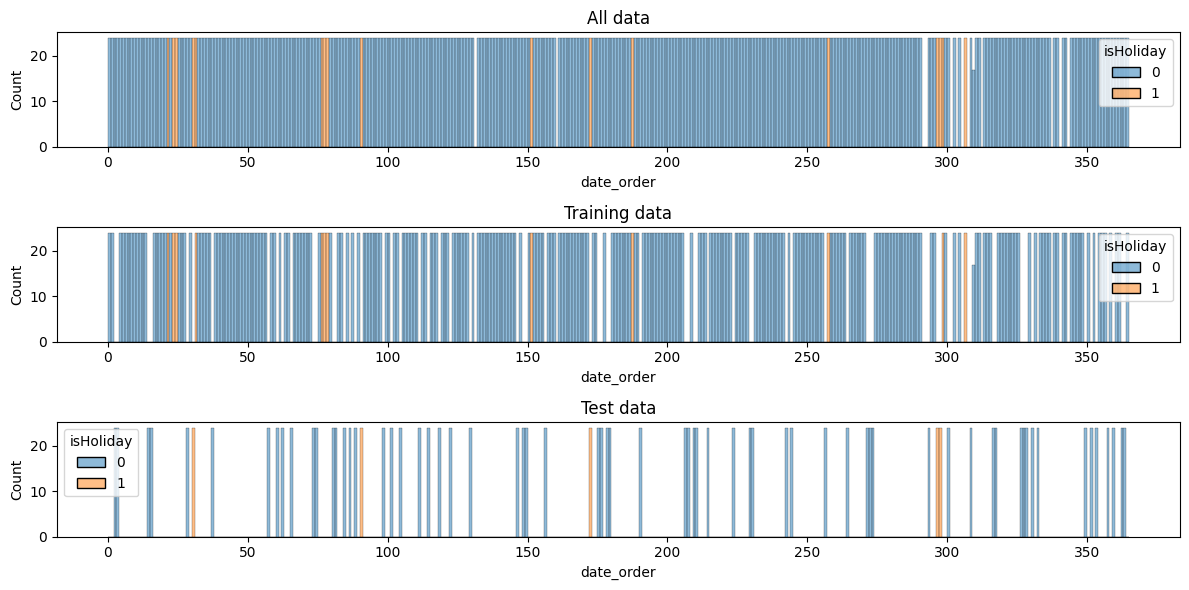

In [143]:
# Check the distribution of the training and test sets over time (days)

#Holiday
feature = "isHoliday"
time = 'date_order'

bin_range = (df_processed[time].min(),df_processed[time].max()+1)

fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(12,6), dpi=100)

with plt.rc_context({'lines.linewidth': 0.8}):
  #All data
  sns.histplot(data=df_processed, x=time, ax=axs[0], binwidth=1, binrange=bin_range, hue=feature, palette="tab10")
  axs[0].set_title("All data")
  #Training
  sns.histplot(data=df_train, x=time, ax=axs[1], binwidth=1, binrange=bin_range, hue=feature, palette="tab10")
  axs[1].set_title("Training data")
  #Test
  sns.histplot(data=df_test, x=time, ax=axs[2], binwidth=1, binrange=bin_range, hue=feature, palette="tab10")
  axs[2].set_title("Test data")

plt.tight_layout()

print("###### Overall ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[time].mean(), df_processed[time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f" % (df_train[time].mean(), df_train[time].std()))
print("Test data: Mean = %0.2f, Std = %0.2f \n" % (df_test[time].mean(), df_test[time].std()))

print("###### isHoliday = 1 ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[df_processed[feature]==1][time].mean(), df_processed[df_processed[feature]==1][time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f" % (df_train[df_train[feature]==1][time].mean(), df_train[df_train[feature]==1][time].std()))
print("Share of holiday entries in training data: %0.2f%%" % (df_train[df_train[feature]==1][time].count()/df_processed[df_processed[feature]==1][time].count()*100))
print("Test data: Mean = %0.2f, Std = %0.2f" % (df_test[df_test[feature]==1][time].mean(), df_test[df_test[feature]==1][time].std()))
print("Share of holiday entries in test data: %0.2f%% \n" % (df_test[df_test[feature]==1][time].count()/df_processed[df_processed[feature]==1][time].count()*100))


###### Overall ######
All data: Mean = 178.38, Std = 104.68
Training data: Mean = 175.75, Std = 103.34 

###### is Weekday ######
All data: Mean = 179.00, Std = 104.91
Training data: Mean = 174.44, Std = 104.77
Share of weekday entries in training: 79.28%
Test data: Mean = 196.44, Std = 103.62
Share of weekday entries in test data: 20.72% 

###### is not Weekday ######
All data: Mean = 176.88, Std = 104.13
Training data: Mean = 178.89, Std = 99.75
Share of not weekday entries in training: 81.32%
Test data: Mean = 168.11, Std = 121.07
Share of not weekday entries in test data: 18.68% 



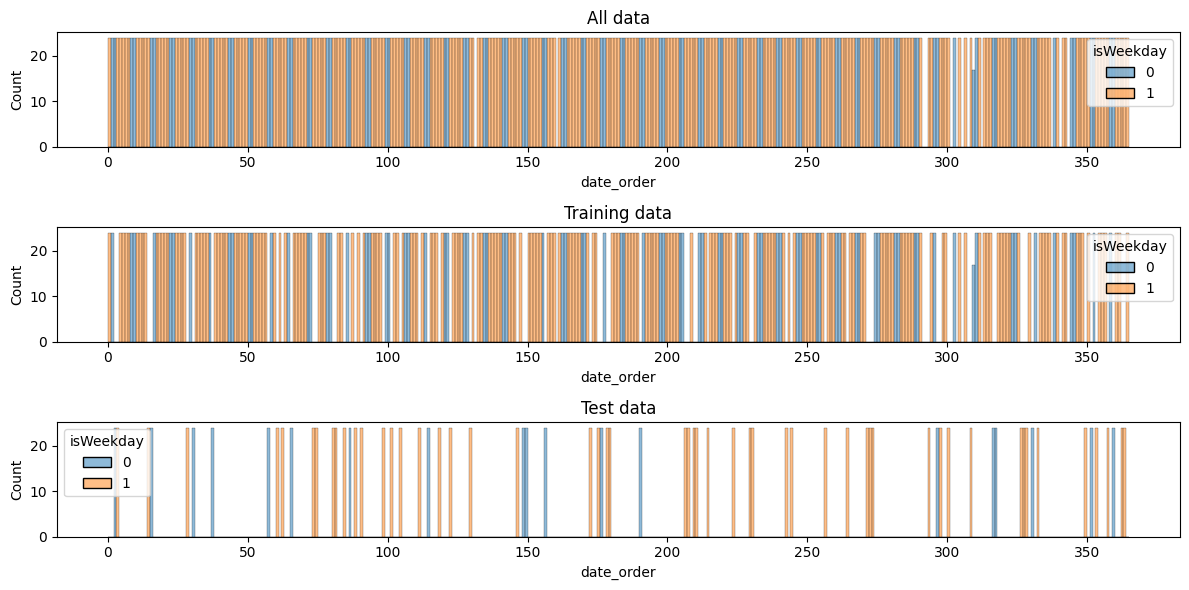

In [145]:
# Check the distribution of the training and test sets over time (days)

# Weekday
feature = "isWeekday"
time = 'date_order'

fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(12,6), dpi=100)
with plt.rc_context({'lines.linewidth': 0.8}):
  # All data
  ax0 = sns.histplot(data=df_processed, x=time, ax=axs[0], binwidth=1, binrange=(df_processed[time].min(),df_processed[time].max()+1), hue=feature, palette="tab10")
  ax0.set_title("All data")
  # Training
  ax1 = sns.histplot(data=df_train, x=time, ax=axs[1], binwidth=1, binrange=(df_processed[time].min(),df_processed[time].max()+1), hue=feature, palette="tab10")
  ax1.set_title("Training data")
  # Test
  ax2 = sns.histplot(data=df_test, x=time, ax=axs[2], binwidth=1, binrange=(df_processed[time].min(),df_processed[time].max()+1), hue=feature, palette="tab10")
  ax2.set_title("Test data")

plt.tight_layout()

print("###### Overall ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[time].mean(), df_processed[time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f \n" % (df_train[time].mean(), df_train[time].std()))

print("###### is Weekday ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[df_processed[feature]==1][time].mean(), df_processed[df_processed[feature]==1][time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f" % (df_train[df_train[feature]==1][time].mean(), df_train[df_train[feature]==1][time].std()))
print("Share of weekday entries in training: %0.2f%%" % (df_train[df_train[feature]==1][time].count()/df_processed[df_processed[feature]==1][time].count()*100))
print("Test data: Mean = %0.2f, Std = %0.2f" % (df_test[df_test[feature]==1][time].mean(), df_test[df_test[feature]==1][time].std()))
print("Share of weekday entries in test data: %0.2f%% \n" % (df_test[df_test[feature]==1][time].count()/df_processed[df_processed[feature]==1][time].count()*100))

print("###### is not Weekday ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[df_processed[feature]==0][time].mean(), df_processed[df_processed[feature]==0][time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f" % (df_train[df_train[feature]==0][time].mean(), df_train[df_train[feature]==0][time].std()))
print("Share of not weekday entries in training: %0.2f%%" % (df_train[df_train[feature]==0][time].count()/df_processed[df_processed[feature]==0][time].count()*100))
print("Test data: Mean = %0.2f, Std = %0.2f" % (df_test[df_test[feature]==0][time].mean(), df_test[df_test[feature]==0][time].std()))
print("Share of not weekday entries in test data: %0.2f%% \n" % (df_test[df_test[feature]==0][time].count()/df_processed[df_processed[feature]==0][time].count()*100))


###### Overall ######
All data: Mean = 11.51, Std = 6.92
Training data: Mean = 11.51, Std = 6.92
Test data: Mean = 11.50, Std = 6.92 

###### isHoliday = 1 ######
All data: Mean = 11.50, Std = 6.93
Training data: Mean = 11.50, Std = 6.93
Share of holiday entries in training data: 70.59%
Test data: Mean = 11.50, Std = 6.95
Share of holiday entries in test data: 29.41% 



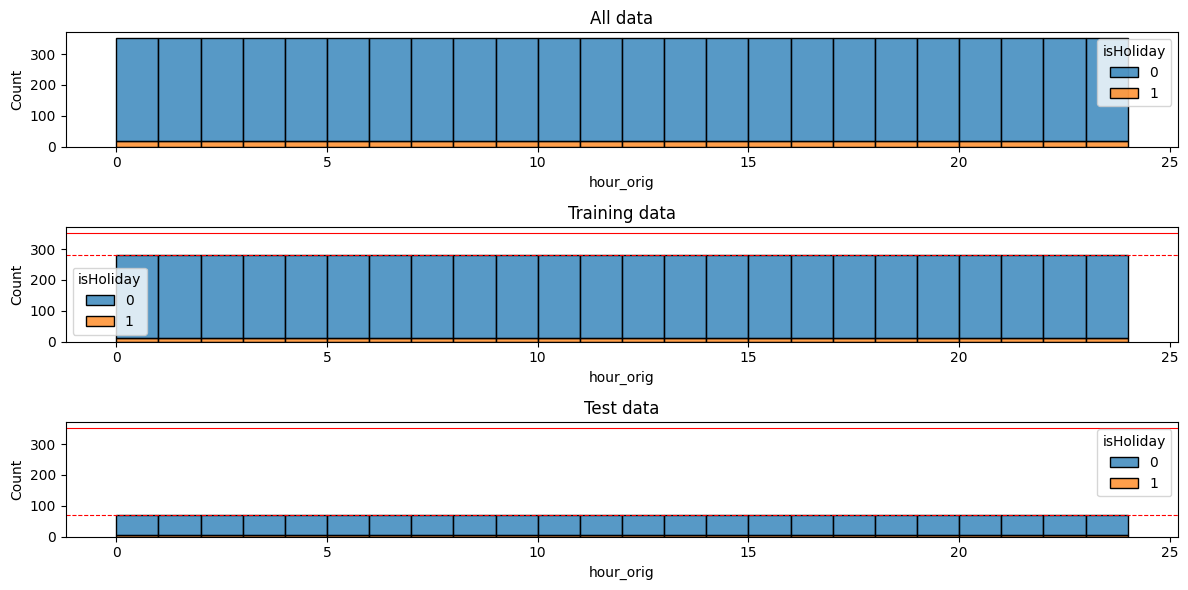

In [146]:
# Check the distribution of the training and test sets over time (hours)

#Holiday
feature = "isHoliday"
time = 'hour_orig'

bin_range = (df_processed[time].min(),df_processed[time].max()+1)

fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(12,6), dpi=100)

with plt.rc_context({'lines.linewidth': 0.8}):
  #All data
  sns.histplot(data=df_processed, x=time, ax=axs[0], binwidth=1, binrange=bin_range, hue=feature, palette="tab10", multiple="stack")
  axs[0].set_title("All data")
  #Training
  sns.histplot(data=df_train, x=time, ax=axs[1], binwidth=1, binrange=bin_range, hue=feature, palette="tab10", multiple="stack")
  axs[1].set_title("Training data")
  axs[1].axhline(y=353, color='r')
  axs[1].axhline(y=353*0.8, color='r', linestyle="--")
  #Test
  sns.histplot(data=df_test, x=time, ax=axs[2], binwidth=1, binrange=bin_range, hue=feature, palette="tab10", multiple="stack")
  axs[2].set_title("Test data")
  axs[2].axhline(y=353, color='r')
  axs[2].axhline(y=353*0.2, color='r', linestyle="--")

plt.tight_layout()

print("###### Overall ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[time].mean(), df_processed[time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f" % (df_train[time].mean(), df_train[time].std()))
print("Test data: Mean = %0.2f, Std = %0.2f \n" % (df_test[time].mean(), df_test[time].std()))

print("###### isHoliday = 1 ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[df_processed[feature]==1][time].mean(), df_processed[df_processed[feature]==1][time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f" % (df_train[df_train[feature]==1][time].mean(), df_train[df_train[feature]==1][time].std()))
print("Share of holiday entries in training data: %0.2f%%" % (df_train[df_train[feature]==1][time].count()/df_processed[df_processed[feature]==1][time].count()*100))
print("Test data: Mean = %0.2f, Std = %0.2f" % (df_test[df_test[feature]==1][time].mean(), df_test[df_test[feature]==1][time].std()))
print("Share of holiday entries in test data: %0.2f%% \n" % (df_test[df_test[feature]==1][time].count()/df_processed[df_processed[feature]==1][time].count()*100))


###### Overall ######
All data: Mean = 11.51, Std = 6.92
Training data: Mean = 11.51, Std = 6.92 

###### is Weekday ######
All data: Mean = 11.50, Std = 6.92
Training data: Mean = 11.50, Std = 6.92
Share of weekday entries in training: 79.28%
Test data: Mean = 11.50, Std = 6.92
Share of weekday entries in test data: 20.72% 

###### is not Weekday ######
All data: Mean = 11.52, Std = 6.92
Training data: Mean = 11.53, Std = 6.92
Share of not weekday entries in training: 81.32%
Test data: Mean = 11.50, Std = 6.93
Share of not weekday entries in test data: 18.68% 



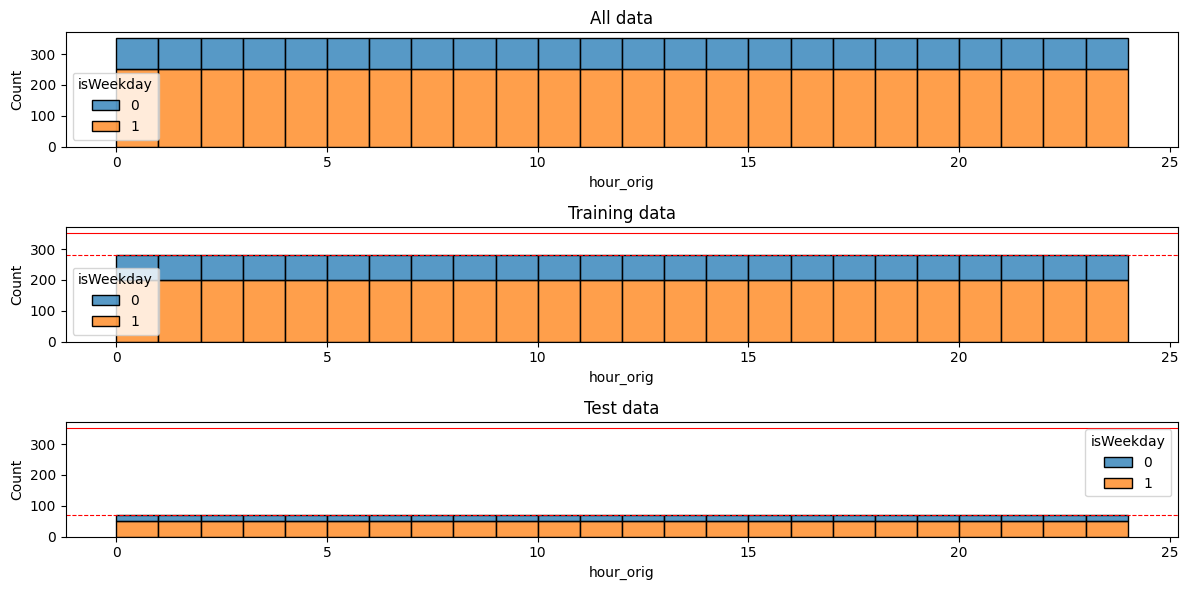

In [147]:
# Check the distribution of the training and test sets over time (Hours)

# Weekday
feature = "isWeekday"
time = 'hour_orig'

bin_range = (df_processed[time].min(),df_processed[time].max()+1)

fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(12,6), dpi=100)
with plt.rc_context({'lines.linewidth': 0.8}):
  ax0 = sns.histplot(data=df_processed, x=time, ax=axs[0], binwidth=1, binrange=bin_range, hue=feature, palette="tab10", multiple="stack")
  ax0.set_title("All data")
  ax1 = sns.histplot(data=df_train, x=time, ax=axs[1], binwidth=1, binrange=bin_range, hue=feature, palette="tab10", multiple="stack")
  ax1.set_title("Training data")
  ax1.axhline(y=353, color='r')
  ax1.axhline(y=353*0.8, color='r', linestyle="--")
  ax2 = sns.histplot(data=df_test, x=time, ax=axs[2], binwidth=1, binrange=bin_range, hue=feature, palette="tab10", multiple="stack")
  ax2.set_title("Test data")
  ax2.axhline(y=353, color='r')
  ax2.axhline(y=353*0.2, color='r', linestyle="--")

plt.tight_layout()

print("###### Overall ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[time].mean(), df_processed[time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f \n" % (df_train[time].mean(), df_train[time].std()))

print("###### is Weekday ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[df_processed[feature]==1][time].mean(), df_processed[df_processed[feature]==1][time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f" % (df_train[df_train[feature]==1][time].mean(), df_train[df_train[feature]==1][time].std()))
print("Share of weekday entries in training: %0.2f%%" % (df_train[df_train[feature]==1][time].count()/df_processed[df_processed[feature]==1][time].count()*100))
print("Test data: Mean = %0.2f, Std = %0.2f" % (df_test[df_test[feature]==1][time].mean(), df_test[df_test[feature]==1][time].std()))
print("Share of weekday entries in test data: %0.2f%% \n" % (df_test[df_test[feature]==1][time].count()/df_processed[df_processed[feature]==1][time].count()*100))

print("###### is not Weekday ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[df_processed[feature]==0][time].mean(), df_processed[df_processed[feature]==0][time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f" % (df_train[df_train[feature]==0][time].mean(), df_train[df_train[feature]==0][time].std()))
print("Share of not weekday entries in training: %0.2f%%" % (df_train[df_train[feature]==0][time].count()/df_processed[df_processed[feature]==0][time].count()*100))
print("Test data: Mean = %0.2f, Std = %0.2f" % (df_test[df_test[feature]==0][time].mean(), df_test[df_test[feature]==0][time].std()))
print("Share of not weekday entries in test data: %0.2f%% \n" % (df_test[df_test[feature]==0][time].count()/df_processed[df_processed[feature]==0][time].count()*100))


#### Comparing versions of time atributes

We created a master version of the training and test data sets and performed the adversarial validation. Now, we want to create three versions of these sets. Let's name them:
* v1: for the original time attributes extracted from the 'Date' information in the raw data set ('hour_orig', 'month_orig', 'date_order'), in addition to other unrelated features (weather plus categorical attributes)
* v2: for the cyclic time attributes ('month_sin/cos', 'date_sin/cos', 'hour_sin/cos'), in addition to other unrelated features (weather plus categorical attributes)
* v3: for the time attributes from one-hot encoding (for month and hour), the original 'date_order' (days since start of data set - since encoding each day of the year would result in too many features), in addition to other unrelated features (weather plus categorical attributes)

Note that if we wanted to predict the future demand (past Nov 30th 2018), we would have to rethink a bit these choices of the time variables. For example, we might need to consider the year and maybe the day of the year (1-365) instead of the day from the start of the data set. However, since we do not have future data in this case, we will keep the current variables.

Furthermore, we would need to consider weather predictions instead of weather data in the modeling.

In [149]:
# Checking current attributes

df_train.columns.values

# Note that the target is current in column 0

array(['Bike_Count', 'Temperature', 'Humidity', 'Wind', 'Vis',
       'Solar_rad', 'Rain', 'Snow', 'date_order', 'Rain_day', 'Snow_day',
       'isWeekday', 'isHoliday', 'week_day_encoded', 'month_sin',
       'month_cos', 'month_orig', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'date_sin', 'date_cos', 'hour_sin',
       'hour_cos', 'hour_orig', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4',
       'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10',
       'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16',
       'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22',
       'Hour_23'], dtype=object)

In [150]:
# Define the relevant column names
#   Weather
weather_attributes = ['Temperature', 'Humidity', 'Wind', 'Vis', 'Solar_rad', 'Rain', 'Snow']

#   Time
time_attributes_v1 = ['date_order', 'month_orig', 'hour_orig']
time_attributes_v2 = ['date_sin', 'date_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos']
time_attributes_v3 = ['date_order', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
                          'month_8', 'month_9', 'month_10', 'month_11', 'month_12','Hour_1', 'Hour_2', 'Hour_3',
                          'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11',
                          'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19',
                          'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23']

#   Categorical
cat_attributes_original = ['isHoliday', 'isWeekday'] # 'isWeekday' will be used instead of 'week_day_encoded', given results of exploratory data analysis
cat_attributes_new = ['Rain_day', 'Snow_day']


In [151]:
# Creating the lists of relevant features for each version of the data set

# v1
features_v1 = time_attributes_v1 + weather_attributes + cat_attributes_original #+ cat_attributes_new

#v2
features_v2 = time_attributes_v2 + weather_attributes + cat_attributes_original #+ cat_attributes_new

#v3
features_v3 = time_attributes_v3 + weather_attributes + cat_attributes_original #+ cat_attributes_new

Clearly v3 has a significant larger number of attributes than v1 and v2 due to the One-Hot encoding.

Now that we have the three versions of the attributes data set (X) for both training and testing, let's  perform the feature selection for the three subsets to undestand which attributes are most important.

### Feature Selection

We will test three strategies to perform the feature selection, in addition to the pre-selection we have already applied:
* SelectKBest
* Recursive Feature Elimination (RFE)
* Tree-based feature selection (using ExtraTreesRegressor)

#### SelectKBest

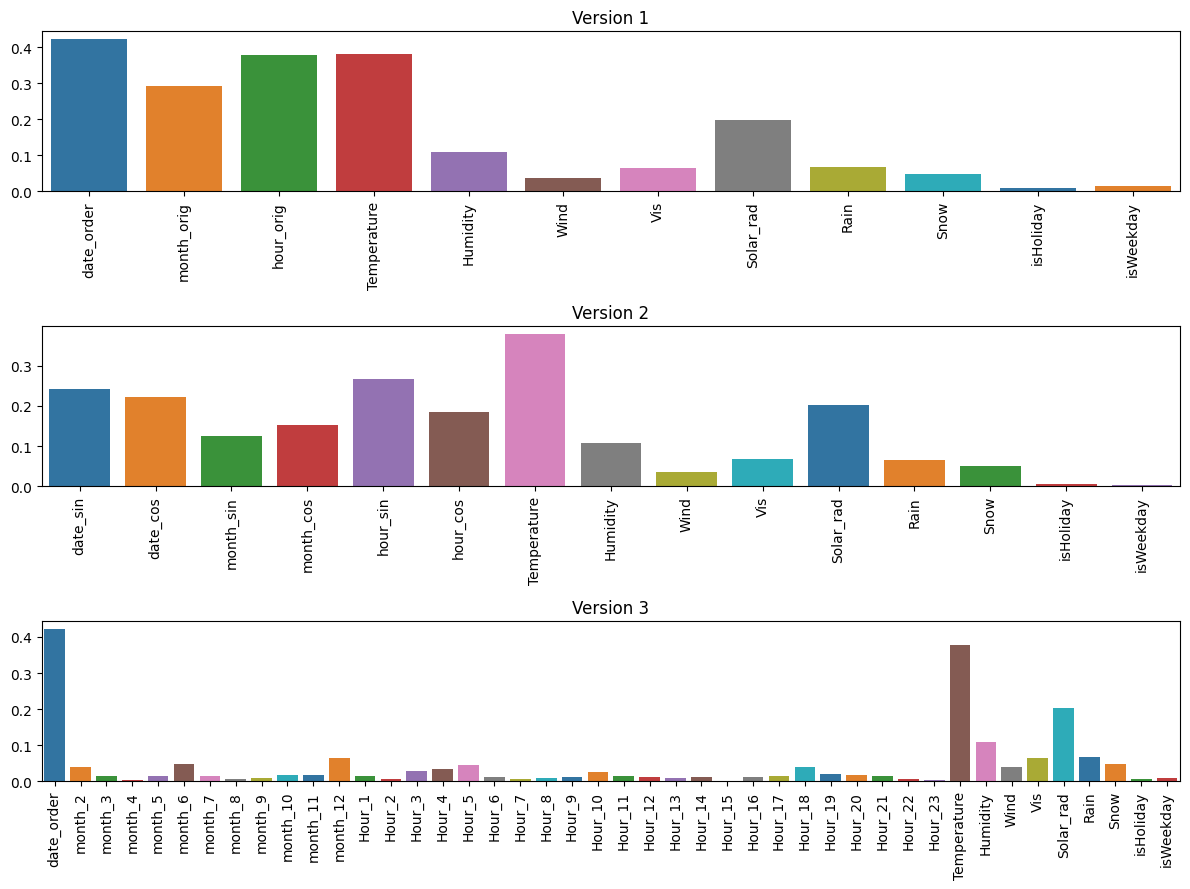

In [152]:
# Setting list of features by version to be used in the feature selection
features_list = [features_v1, features_v2, features_v3]

# Setting up SelectKBest
best_attributes = SelectKBest(score_func=mutual_info_regression, k='all')

# Create list to append scores per version
attribute_scores = []

# Get the training y values (do not vary by version)
y_train = df_train['Bike_Count']

# Plot the features and scores for each version
fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(12,9), dpi=100)
for i in range(len(features_list)):
  # Select training data from DataFrame based on list of attributes for version i+1
  X_selected = df_train[features_list[i]]
  # Fit and get scores
  best_attributes.fit(X_selected, y_train) # y values do not change for the different versions
  attribute_scores.append(best_attributes.scores_)
  # Plot figure for comparison
  sns.barplot(x=X_selected.columns, y=best_attributes.scores_, ax = axs[i], palette='tab10')
  axs[i].set(xlabel=None)
  axs[i].set_xticklabels(X_selected.columns, rotation=90)
  axs[i].set_title('Version %i' % (i+1))

plt.tight_layout()

In [153]:
# Features in order of importance and their scores for the three versions from SelectKBest

for i in range(len(features_list)):
  df_features = pd.DataFrame({'features':features_list[i], 'scores':attribute_scores[i]})
  print("#######  Version %i  #######" % (i+1))
  print(df_features.sort_values(by=['scores'], ascending=False))
  print("\n")

#######  Version 1  #######
       features    scores
0    date_order  0.423189
3   Temperature  0.381408
2     hour_orig  0.379382
1    month_orig  0.291333
7     Solar_rad  0.197846
4      Humidity  0.108683
8          Rain  0.066149
6           Vis  0.063170
9          Snow  0.047158
5          Wind  0.036998
11    isWeekday  0.015032
10    isHoliday  0.009602


#######  Version 2  #######
       features    scores
6   Temperature  0.379448
4      hour_sin  0.268111
0      date_sin  0.242043
1      date_cos  0.223058
10    Solar_rad  0.201380
5      hour_cos  0.184272
3     month_cos  0.152122
2     month_sin  0.124533
7      Humidity  0.106881
9           Vis  0.067218
11         Rain  0.066001
12         Snow  0.050552
8          Wind  0.036273
13    isHoliday  0.004416
14    isWeekday  0.003845


#######  Version 3  #######
       features    scores
0    date_order  0.422354
35  Temperature  0.379073
39    Solar_rad  0.203915
36     Humidity  0.107467
40         Rain  0.066825
11

Note that:
* The time features are tagged as some of the most important features
* `Temperature`, `Solar Radiation`, `Humidity`, and `Rain` are the four most important weather-based attributes (out of the 7 given)
* The selection of holiday vs. non-holiday is also not within the most important attributes, but we should recall that only 5% of the data is tagged as holidays, so it is possible that the low statistics could impact the importance here.

#### Recursive Feature Elimination

In [154]:
# Setting list of features by version to be used in the feature selection
features_list = [features_v1, features_v2, features_v3]

# Selecting algorithm
#model_RFE = LinearRegression()
model_RFE = DecisionTreeRegressor()
#model_RFE = SVR(kernel="rbf")

# Setting up the RFE
rfe = RFE(model_RFE, n_features_to_select=None)

# Create list to append ranking per version
attribute_ranking_rfe = []

# Get the training y values (do not vary by version)
y_train = df_train['Bike_Count']

# Get the features and ranking for each version
for i in range(len(features_list)):
  # Select training data from DataFrame based on list of attributes for version i+1
  X_selected = df_train[features_list[i]]
  # Fit and get scores
  rfe.fit(X_selected, y_train) # y values do not change for the different versions
  attribute_ranking_rfe.append(rfe.ranking_)
  df_features = pd.DataFrame({'features':features_list[i], 'ranking':rfe.ranking_})
  print("#######  Version %i  #######" % (i+1))
  print(df_features.sort_values(by=['ranking'], ascending=True))
  print("\n")


#######  Version 1  #######
       features  ranking
0    date_order        1
2     hour_orig        1
3   Temperature        1
4      Humidity        1
7     Solar_rad        1
11    isWeekday        1
8          Rain        2
5          Wind        3
6           Vis        4
10    isHoliday        5
1    month_orig        6
9          Snow        7


#######  Version 2  #######
       features  ranking
0      date_sin        1
1      date_cos        1
4      hour_sin        1
5      hour_cos        1
6   Temperature        1
7      Humidity        1
10    Solar_rad        1
14    isWeekday        2
11         Rain        3
9           Vis        4
8          Wind        5
13    isHoliday        6
3     month_cos        7
2     month_sin        8
12         Snow        9


#######  Version 3  #######
       features  ranking
0    date_order        1
27      Hour_16        1
28      Hour_17        1
29      Hour_18        1
30      Hour_19        1
31      Hour_20        1
32      Hour

Based on the RFE feature ranking above:
* We can see that again the versions can show differences regarding the time variables
* The weather-based variables that are ranked as **1** in all three versions are: `Temperature`, `Humidity`, `Solar Radiation`
* `Rain` has also been ranked relatively high
* The weekday tagging feature (`isWeekday`) also was ranked as more important than with SelectKBest.

#### Tree-based feature selection - using ExtraTreesRegressor

In [157]:
# Setting list of features by version to be used in the feature selection
features_list = [features_v1, features_v2, features_v3]

# Selecting algorithm
model_ET = ExtraTreesRegressor(n_estimators=100)

# Create list to append scores per version
attribute_scores_ET = []

# Get the training and test y values (do not vary by version)
y_train = df_train['Bike_Count']
y_test = df_test['Bike_Count']

# Get the features and scores for each version
for i in range(len(features_list)):
  # Select training and test data from DataFrame based on list of attributes for version i+1
  X_selected = df_train[features_list[i]]
  X_test = df_test[features_list[i]]
  # Fit and get scores
  model_ET.fit(X_selected, y_train) # y values do not change for the different versions
  # Get prediction and R^2
  r2 = r2_score(y_test, model_ET.predict(X_test))
  # Append attribute importances
  attribute_scores_ET.append(model_ET.feature_importances_)
  df_features = pd.DataFrame({'features':features_list[i], 'score':model_ET.feature_importances_})
  print("#######  Version %i  #######" % (i+1))
  print(df_features.sort_values(by=['score'], ascending=False))
  print("R^2: %0.3f" % r2)
  print("\n")

#######  Version 1  #######
       features     score
2     hour_orig  0.330623
3   Temperature  0.205474
0    date_order  0.157012
4      Humidity  0.092872
7     Solar_rad  0.066648
1    month_orig  0.047675
11    isWeekday  0.035475
6           Vis  0.022202
8          Rain  0.021803
5          Wind  0.012987
10    isHoliday  0.006417
9          Snow  0.000814
R^2: 0.909


#######  Version 2  #######
       features     score
4      hour_sin  0.264130
6   Temperature  0.230434
7      Humidity  0.086083
5      hour_cos  0.086066
0      date_sin  0.069651
3     month_cos  0.055158
10    Solar_rad  0.050171
14    isWeekday  0.036469
2     month_sin  0.035046
1      date_cos  0.032977
11         Rain  0.021110
9           Vis  0.015950
8          Wind  0.009657
13    isHoliday  0.006266
12         Snow  0.000835
R^2: 0.902


#######  Version 3  #######
       features     score
35  Temperature  0.218660
0    date_order  0.122329
36     Humidity  0.120402
29      Hour_18  0.080096
43    

Using this method to assess feature importance, we can observe that:
* We can see that again the versions can show differences regarding the time variables
* The most important weather-based variables in all three versions are again: `Temperature`, `Humidity`, `Solar Radiation`, and `Rain`
* The weekday tagging feature (`isWeekday`) also was ranked as more important than with SelectKBest, as in the RFE method.

#### Conclusions from Feature Selection

Based on the observations we had from the three methods to assess feature importance in our training data, we can conclude that:
* The different methods are in overall agreement that `Temperature`, `Humidity`, `Solar Radiation`, and `Rain` are the most important weather-based features, and therefore will be selected for the modeling.
  * If we were considering pediction for future days, we would need probabilities for these features predictions, and therefore the model would need to be updated.
* The month related features are usually ranked lower than other time attributes. This makes sense, as we only have one year of data and the date from the start of the data set is providing better scores. Therefore, it seems redundant to include the month features when `date_order` (v1 and v3) and `date_sin/cos` (v2) should provide more refined information.
* From the categorical features, it seems like neither `isWeekday` or `isHoliday` are very important. However, `isWeekday` did rank close to the top weather-based features in the RFE and ExtraTrees methods. It is also possible that `isHoliday` did not rank higher due to the lower statistics presented for this category. For now we will keep both for now.

Let's build below the updated list of features to be used in the modeling section.

In [185]:
# Define selected features
#   Weather
selected_weather_attributes = ['Temperature', 'Humidity', 'Solar_rad', 'Rain']

#   Time
selected_time_attributes_v1 = ['month_orig', 'hour_orig']#['date_order', 'hour_orig']
selected_time_attributes_v2 = ['date_sin', 'date_cos', 'hour_sin', 'hour_cos']
selected_time_attributes_v3 = ['date_order', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7',
                               'Hour_8', 'Hour_9', 'Hour_10','Hour_11','Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                               'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20','Hour_21', 'Hour_22', 'Hour_23']

#   Categorical
selected_cat_attributes_original = ['isWeekday', 'isHoliday']

# Creating list of total selected features per version
selected_features_v1 = selected_time_attributes_v1 + selected_weather_attributes + selected_cat_attributes_original
selected_features_v2 = selected_time_attributes_v2 + selected_weather_attributes + selected_cat_attributes_original
selected_features_v3 = selected_time_attributes_v3 + selected_weather_attributes + selected_cat_attributes_original

#### Testing the selected features

Using the ExtraTrees estimator to assess the importance of the selected features.

In [172]:
# Setting list of features by version
selected_features_list = [selected_features_v1, selected_features_v2, selected_features_v3]

# Selecting algorithm
model_ET = ExtraTreesRegressor(n_estimators=100)

# Create list to append scores per version
attribute_scores_ET = []

# Get the training and test y values (do not vary by version)
y_train = df_train['Bike_Count']
y_test = df_test['Bike_Count']

# Get the features and scores for each version
for i in range(len(selected_features_list)):
  # Select training and test data from DataFrame based on list of attributes for version i+1
  X_selected = df_train[selected_features_list[i]]
  X_test = df_test[selected_features_list[i]]
  # Fit and get scores
  model_ET.fit(X_selected, y_train) # y values do not change for the different versions
  # Get prediction and R^2
  r2 = r2_score(y_test, model_ET.predict(X_test))
  # Append attribute importances
  attribute_scores_ET.append(model_ET.feature_importances_)
  df_features = pd.DataFrame({'features':selected_features_list[i], 'score':model_ET.feature_importances_})
  print("#######  Version %i  #######" % (i+1))
  print(df_features.sort_values(by=['score'], ascending=False))
  print("R^2: %0.3f" % r2)
  print("\n")

#######  Version 1  #######
      features     score
1    hour_orig  0.335714
2  Temperature  0.270158
0   date_order  0.152491
3     Humidity  0.110282
4    Solar_rad  0.068892
6    isWeekday  0.034287
5         Rain  0.021919
7    isHoliday  0.006258
R^2: 0.912


#######  Version 2  #######
      features     score
4  Temperature  0.263472
2     hour_sin  0.261277
0     date_sin  0.101239
5     Humidity  0.095517
3     hour_cos  0.088662
1     date_cos  0.067676
6    Solar_rad  0.052360
8    isWeekday  0.037352
7         Rain  0.025909
9    isHoliday  0.006537
R^2: 0.912


#######  Version 3  #######
       features     score
24  Temperature  0.253225
0    date_order  0.156471
25     Humidity  0.123859
18      Hour_18  0.079133
26    Solar_rad  0.047191
28    isWeekday  0.042647
19      Hour_19  0.040132
21      Hour_21  0.030594
20      Hour_20  0.030378
17      Hour_17  0.026250
8        Hour_8  0.026007
22      Hour_22  0.022747
27         Rain  0.021779
4        Hour_4  0.015099


As we can see above, there was a small improvement with the selection of the above attributes.

### Cross Validation

Now that we have divided the data set and performed the feature selection, let's prepare the k pairs of training and validation sets for the cross validation.

Similarly to the train/test split with Scikit-learn `GroupShuffleSplit`, we will split the training data set in train/validate sets to perform the cross validation.

Note that:
* We will not use `KFold` due to its inability to keep all entries from the same day (each day has 24 entries - for the 24 hours) in the same set (either train or validate).
* `GroupKFold` could also be used in this case. However, `GroupShuffleSplit` was chosen to try to keep well distributed validation sets. `GroupKFold` would not repeat a group (day) in different validation sets, and we have low statistics of some categories (e.g., holidays).

In [186]:
# Using GroupShuffleSplit to divide the data between train and validation sets

# Number of split and fraction of validation set
n_iterations = 5 # number of training and validation sets
valFraction = 1/n_iterations

# Set up split
gss_cv = GroupShuffleSplit(n_splits=n_iterations, random_state=7, test_size=valFraction)

# Get group of days (days since start of data set) in the training set - which group (day) each entry is part of
groups_cv = df_train['date_order'].values


In [ ]:
# Creating the kfolds for cross validation

n_folds = 5 # number of folds
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=7)

### Scaling: Normalization vs. Padronization

We will test two scaling methods to try to improve the algorithms performances:
* Standardization (StandardScaler)
* Normalization (MinMaxScaler)

However, we should keep in mind that since we expect the best performance to be from tree-based algorithms, the scalers might not have a substantial performance improvement in the best models.

In [187]:
# Scaling transformations that will be tested in the modeling section - to be added to pipelines

standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Modeling

## Data set up

In [188]:
# Setting up the X arrays for training and testing
#  v1
X_train_v1 = df_train[selected_features_v1].values
X_test_v1 = df_test[selected_features_v1].values
#  v2
X_train_v2 = df_train[selected_features_v2].values
X_test_v2 = df_test[selected_features_v2].values
#  v3
X_train_v3 = df_train[selected_features_v3].values
X_test_v3 = df_test[selected_features_v3].values

# Recalling y arrays for training and testing
y_train = df_train['Bike_Count'].values
y_test = df_test['Bike_Count'].values


## Pipelines

In [189]:
# Setting up the pipelines

np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []



# Criando os elementos do pipeline

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeRegressor()
num_trees = 100
max_features = 10
svm_kernel = 'rbf'


# Criando os modelos para o VotingClassifier
bases = []
model1 = LinearRegression()
bases.append(('lr', model1))
model2 = DecisionTreeRegressor()
bases.append(('cart', model2))
model3 = SVR()
bases.append(('svm', model3))

# Algoritmos que serão utilizados
lr = ('LR', LinearRegression())
knn = ('KNN', KNeighborsRegressor())
cart = ('CART', DecisionTreeRegressor())
svm = ('SVM', SVR(kernel=svm_kernel))
bagging = ('Bag', BaggingRegressor(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostRegressor(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingRegressor(n_estimators=num_trees))
voting = ('Voting', VotingRegressor(bases))


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([lr])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, lr])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, lr])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))


## Models comparison

### Features v1

LR-orig: R^2 0.524 (0.009)
KNN-orig: R^2 0.766 (0.011)
CART-orig: R^2 0.850 (0.009)
SVM-orig: R^2 0.171 (0.046)
Bag-orig: R^2 0.912 (0.011)
RF-orig: R^2 0.912 (0.011)
ET-orig: R^2 0.916 (0.007)
Ada-orig: R^2 0.604 (0.050)
GB-orig: R^2 0.865 (0.009)
Vot-orig: R^2 0.690 (0.016)
LR-padr: R^2 0.524 (0.009)
KNN-padr: R^2 0.833 (0.013)
CART-padr: R^2 0.850 (0.014)
SVM-padr: R^2 0.269 (0.032)
Bag-padr: R^2 0.912 (0.011)
RF-padr: R^2 0.912 (0.012)
ET-padr: R^2 0.915 (0.008)
Ada-padr: R^2 0.615 (0.044)
GB-padr: R^2 0.865 (0.009)
Vot-padr: R^2 0.706 (0.012)
LR-norm: R^2 0.524 (0.009)
KNN-norm: R^2 0.839 (0.017)
CART-norm: R^2 0.851 (0.011)
SVM-norm: R^2 0.177 (0.043)
Bag-norm: R^2 0.912 (0.011)
RF-norm: R^2 0.912 (0.011)
ET-norm: R^2 0.917 (0.008)
Ada-norm: R^2 0.605 (0.047)
GB-norm: R^2 0.865 (0.009)
Vot-norm: R^2 0.690 (0.014)


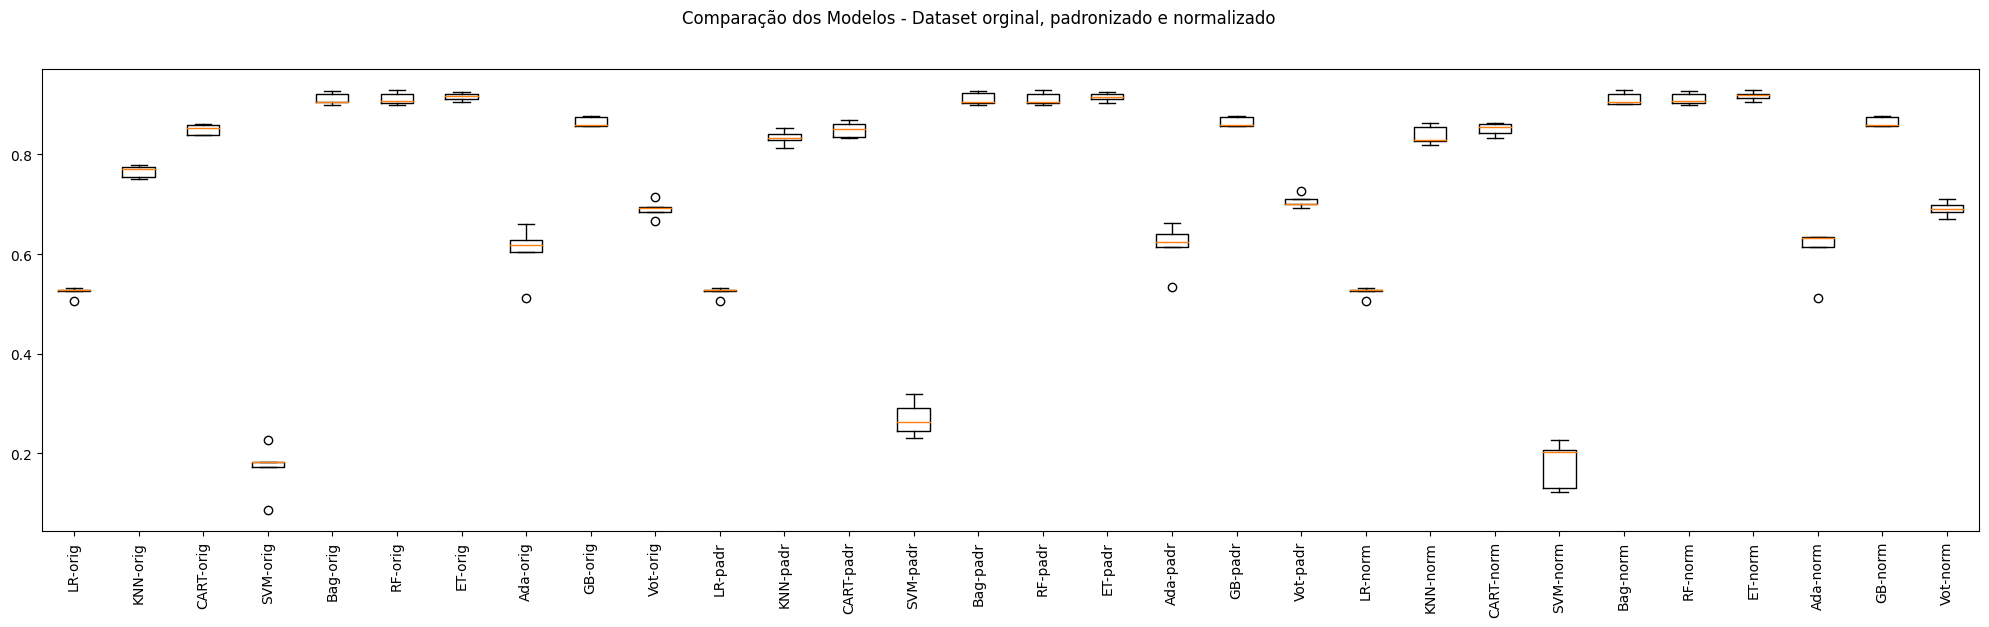

In [190]:
# v1

results = []
names = []

# Executando os pipelines
scoring = 'r2' #'neg_mean_squared_error'

for name, model in pipelines:
    cv_results = cross_val_score(model, X_train_v1, y_train, cv=gss_cv, groups=groups_cv, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
    msg = "%s: R^2 %0.3f (%0.3f)" % (name, abs(cv_results.mean()), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Features v2

LR-orig: R^2 0.520 (0.012)
KNN-orig: R^2 0.636 (0.021)
CART-orig: R^2 0.850 (0.015)
SVM-orig: R^2 0.121 (0.046)
Bag-orig: R^2 0.910 (0.011)
RF-orig: R^2 0.911 (0.011)
ET-orig: R^2 0.920 (0.010)
Ada-orig: R^2 0.581 (0.032)
GB-orig: R^2 0.867 (0.008)
Vot-orig: R^2 0.683 (0.015)
LR-padr: R^2 0.520 (0.012)
KNN-padr: R^2 0.873 (0.014)
CART-padr: R^2 0.847 (0.014)
SVM-padr: R^2 0.260 (0.033)
Bag-padr: R^2 0.912 (0.010)
RF-padr: R^2 0.912 (0.011)
ET-padr: R^2 0.920 (0.010)
Ada-padr: R^2 0.583 (0.032)
GB-padr: R^2 0.868 (0.008)
Vot-padr: R^2 0.702 (0.012)
LR-norm: R^2 0.520 (0.012)
KNN-norm: R^2 0.871 (0.011)
CART-norm: R^2 0.849 (0.016)
SVM-norm: R^2 0.217 (0.039)
Bag-norm: R^2 0.912 (0.011)
RF-norm: R^2 0.912 (0.011)
ET-norm: R^2 0.920 (0.010)
Ada-norm: R^2 0.574 (0.043)
GB-norm: R^2 0.867 (0.008)
Vot-norm: R^2 0.696 (0.014)


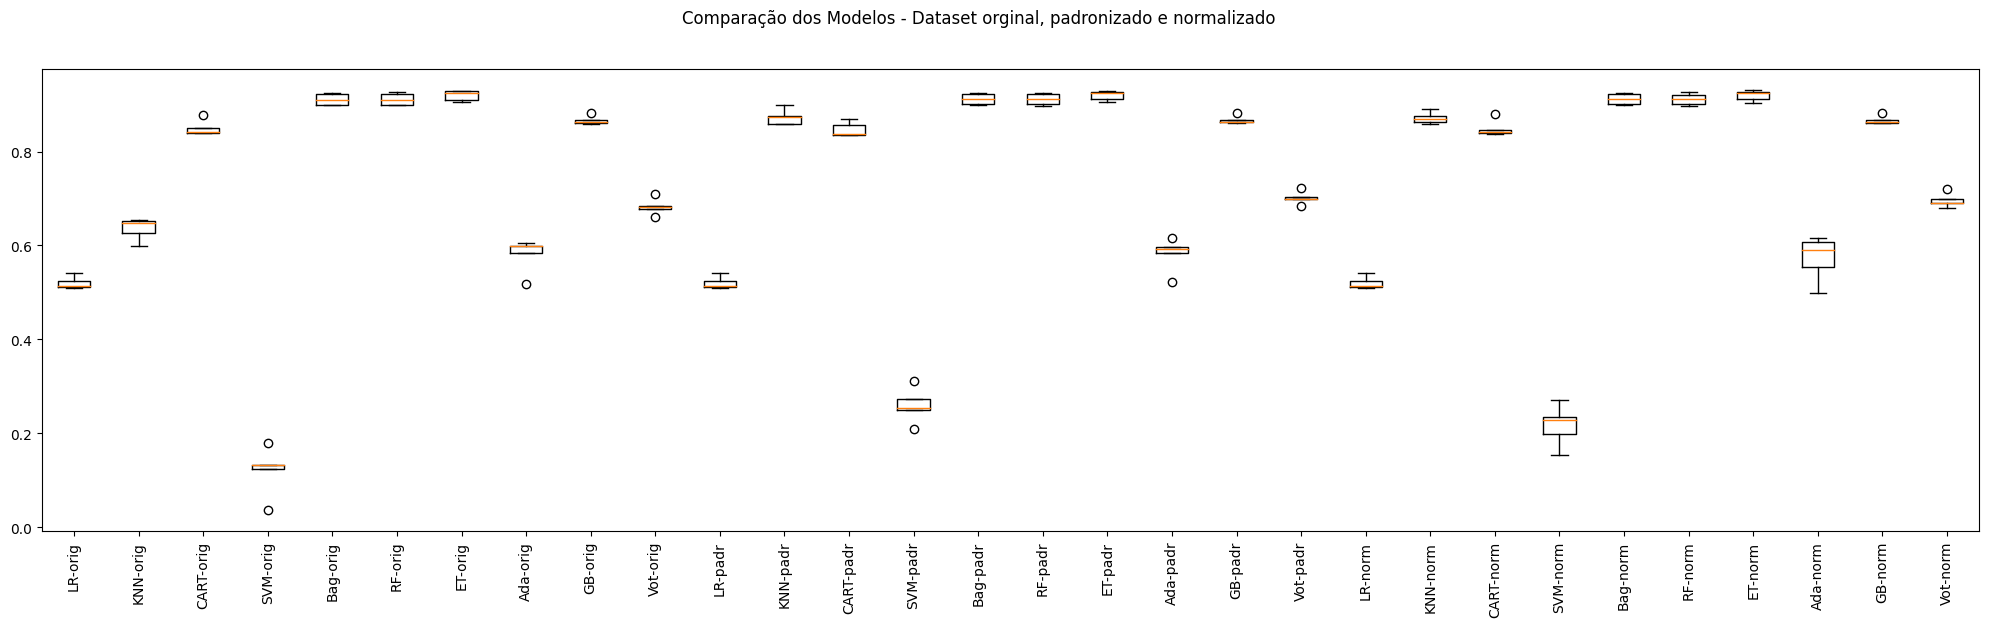

In [180]:
# v2

results = []
names = []

# Executando os pipelines
scoring = 'r2' #'neg_mean_squared_error'
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train_v2, y_train, cv=gss_cv, groups=groups_cv, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
    msg = "%s: R^2 %0.3f (%0.3f)" % (name, abs(cv_results.mean()), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Features v3

LR-orig: R^2 0.649 (0.014)
KNN-orig: R^2 0.579 (0.014)
CART-orig: R^2 0.840 (0.010)
SVM-orig: R^2 0.166 (0.009)
Bag-orig: R^2 0.909 (0.003)
RF-orig: R^2 0.916 (0.002)
ET-orig: R^2 0.917 (0.003)
Ada-orig: R^2 0.408 (0.019)
GB-orig: R^2 0.848 (0.004)
Vot-orig: R^2 0.740 (0.008)
LR-padr: R^2 0.649 (0.014)
KNN-padr: R^2 0.875 (0.004)
CART-padr: R^2 0.837 (0.012)
SVM-padr: R^2 0.098 (0.014)
Bag-padr: R^2 0.909 (0.004)
RF-padr: R^2 0.917 (0.004)
ET-padr: R^2 0.917 (0.003)
Ada-padr: R^2 0.404 (0.030)
GB-padr: R^2 0.848 (0.004)
Vot-padr: R^2 0.733 (0.009)
LR-norm: R^2 0.649 (0.014)
KNN-norm: R^2 0.871 (0.006)
CART-norm: R^2 0.836 (0.013)
SVM-norm: R^2 0.102 (0.011)
Bag-norm: R^2 0.909 (0.004)
RF-norm: R^2 0.917 (0.002)
ET-norm: R^2 0.917 (0.002)
Ada-norm: R^2 0.408 (0.040)
GB-norm: R^2 0.848 (0.004)
Vot-norm: R^2 0.731 (0.006)


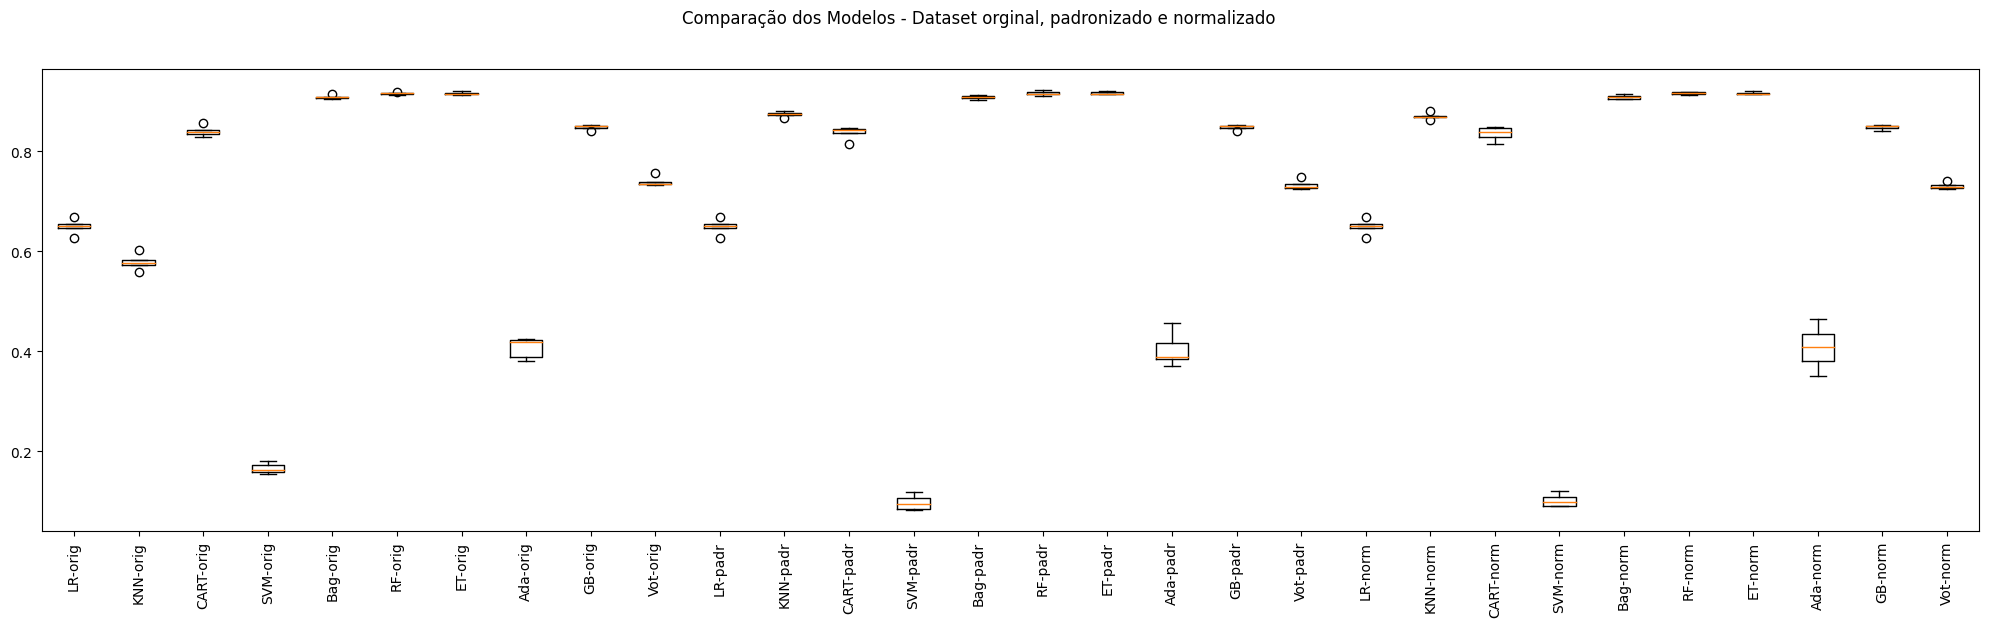

In [ ]:
# v3

results = []
names = []

# Executando os pipelines
scoring = 'r2' #'neg_mean_squared_error'
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train_v3, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
    msg = "%s: R^2 %0.3f (%0.3f)" % (name, abs(cv_results.mean()), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

## Model Selection and training

In [191]:
et_reg = ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features)
et_reg.fit(X_train_v1,y_train)

ExtraTreesRegressor(max_features=10)

In [192]:
prediction = et_reg.predict(X_test_v1)

mse = mean_squared_error(y_test, prediction)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))

r2 = r2_score(y_test, prediction)
print("R^2 %0.3f" % r2)


MSE 34161.40
RMSE 184.83
R^2 0.907


In [246]:
df_result = df_test[selected_features_v1+['Rain_day','date_order']] #pd.DataFrame(X_test_v1,columns=selected_features_v1)
df_result['Bike_Count'] = y_test
df_result['y_predict'] = prediction
df_result['residuals'] = df_result['y_predict']-df_result['Bike_Count']

In [247]:
df_result.head(10)

month_orig  hour_orig  Temperature  Humidity  Solar_rad  Rain  isWeekday  \
48          12          0          4.0        58       0.00   0.0          0   
49          12          1          3.9        69       0.00   0.0          0   
50          12          2          3.3        79       0.00   0.0          0   
51          12          3          3.4        71       0.00   0.5          0   
52          12          4          3.5        73       0.00   0.0          0   
53          12          5          3.9        75       0.00   0.0          0   
54          12          6          3.4        86       0.00   1.0          0   
55          12          7          3.1        91       0.00   0.0          0   
56          12          8          3.2        92       0.00   0.0          0   
57          12          9          3.5        91       0.02   2.5          0   

    isHoliday  Rain_day  date_order  Bike_Count  y_predict  residuals  
48          0         1           2         342     408.40      66.40  
49          0         1           2         227     331.51     104.51  
50          0         1           2         228     251.51      23.51  
51          0         1           2         117     190.15      73.15  
52          0         1           2          76     115.68      39.68  
53          0         1           2          32      62.48      30.48  
54          0         1           2          13      55.18      42.18  
55          0         1           2          22      76.32      54.32  
56          0         1           2          85     107.52      22.52  
57          0         1           2         152     130.00     -22.00

# Analysing the results

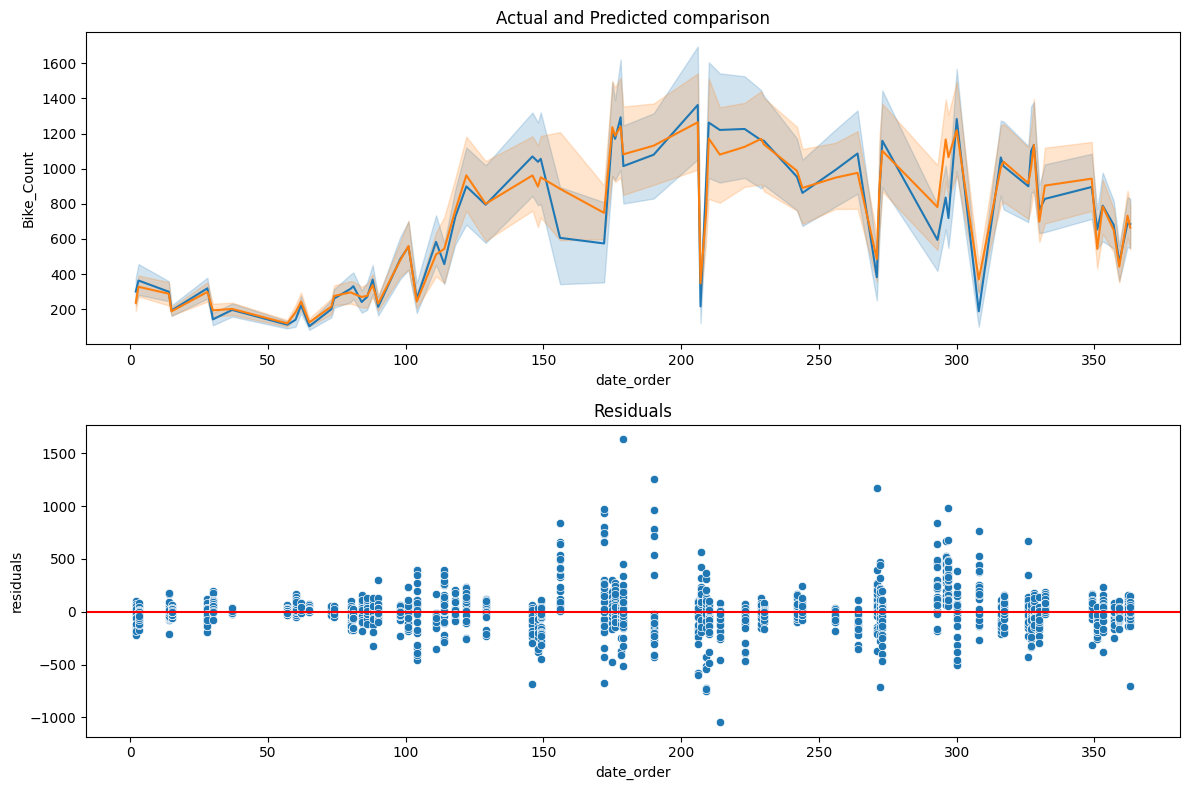

In [264]:
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,8), dpi=100)
#plt.figure(figsize=(12,4))

sns.lineplot(data=df_result, x='date_order', y='Bike_Count', ax=axs[0], palette='tab10')
sns.lineplot(data=df_result, x='date_order', y='y_predict', ax=axs[0], palette='tab10')
sns.scatterplot(data=df_result, x='date_order', y='residuals', ax=axs[1], palette='tab10')

axs[0].set_title("Actual and Predicted comparison")
axs[1].set_title("Residuals")
axs[1].axhline(y=0, color='r')
#axs[2].axhline(y=353*0.2, color='r', linestyle="--")

plt.tight_layout()

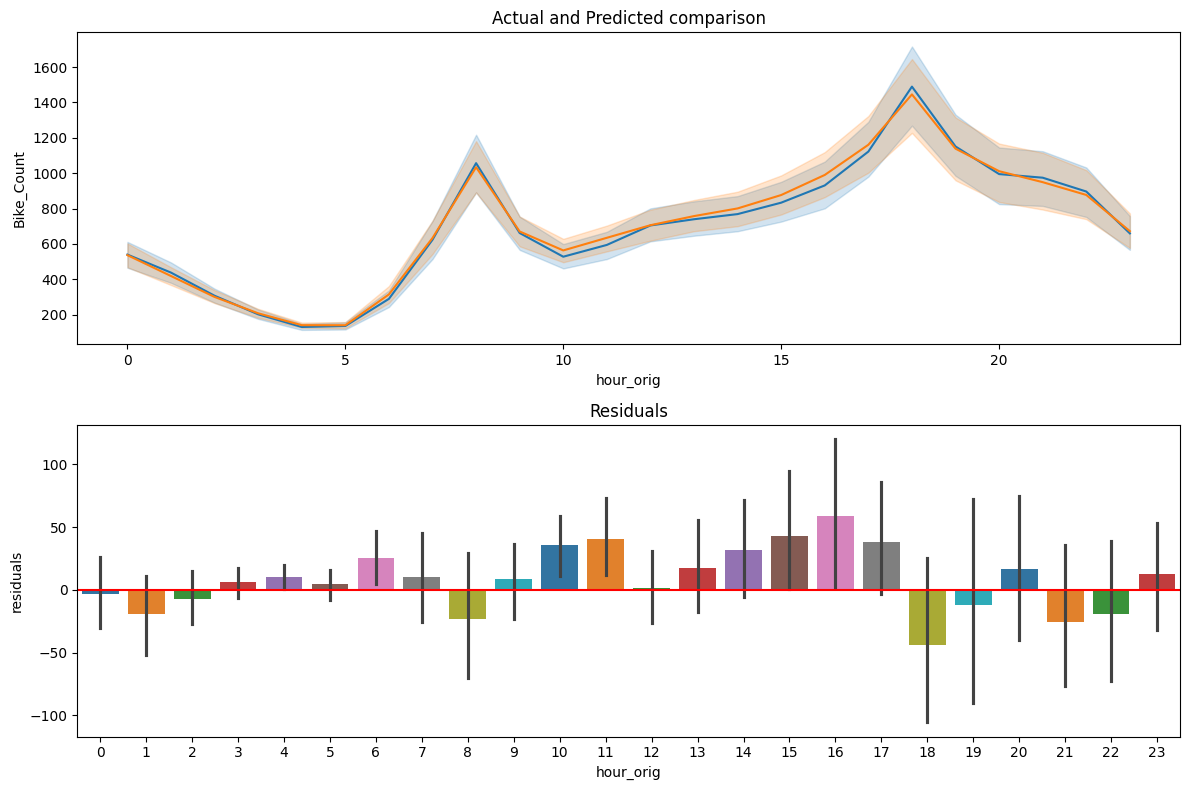

In [249]:
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,8), dpi=100)
#plt.figure(figsize=(12,4))

sns.lineplot(data=df_result, x='hour_orig', y='Bike_Count', ax=axs[0], palette='tab10')
sns.lineplot(data=df_result, x='hour_orig', y='y_predict', ax=axs[0], palette='tab10')
sns.barplot(data=df_result, x='hour_orig', y='residuals', ax=axs[1], palette='tab10')

axs[0].set_title("Actual and Predicted comparison")
axs[1].set_title("Residuals")
axs[1].axhline(y=0, color='r')
#axs[1].set_ylim((-1,2))
#axs[2].axhline(y=353*0.2, color='r', linestyle="--")

plt.tight_layout()

In [258]:
# Daily average
df_result_day = df_result.groupby('date_order')[['Bike_Count','y_predict']].mean().reset_index()
df_result_day['residuals'] = df_result_day['y_predict']-df_result_day['Bike_Count']
df_result_day.head()

date_order  Bike_Count   y_predict  residuals
0           2  300.916667  237.011250 -63.905417
1           3  363.708333  328.107500 -35.600833
2          14  299.916667  288.680833 -11.235833
3          15  193.000000  188.686250  -4.313750
4          28  319.291667  298.823333 -20.468333

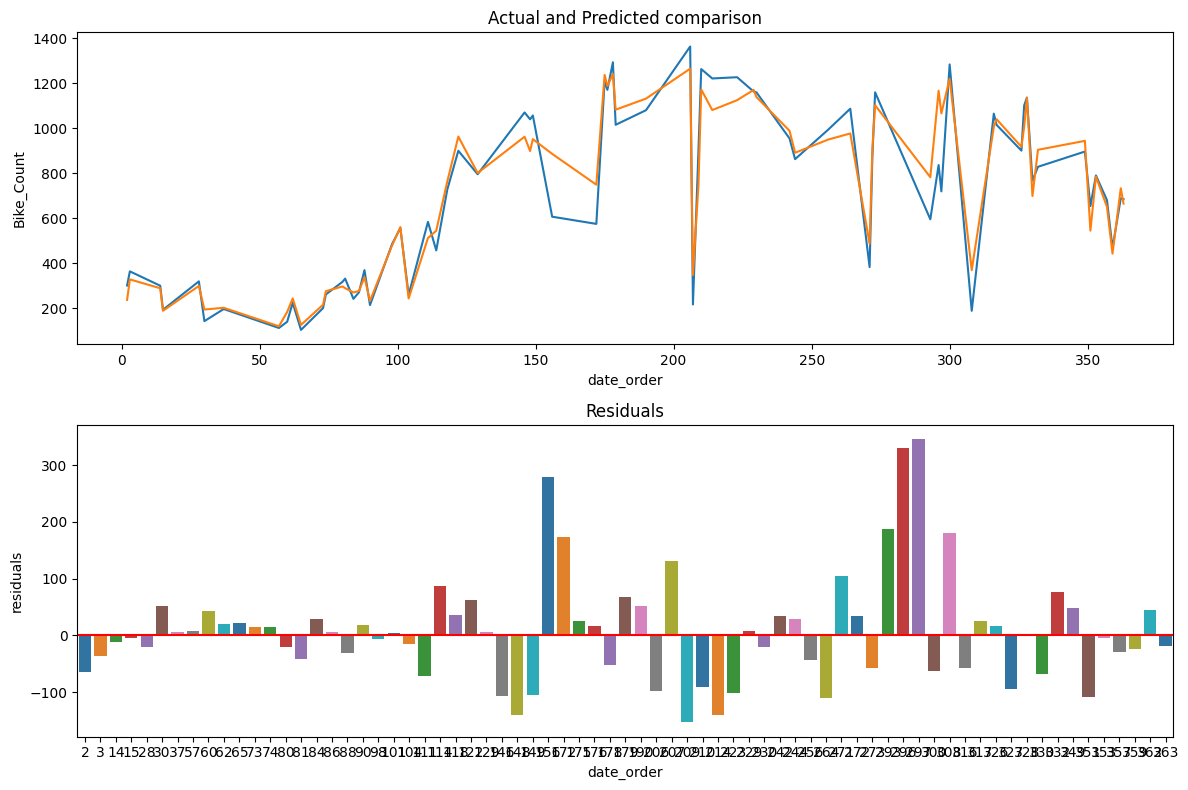

In [259]:
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,8), dpi=100)
#plt.figure(figsize=(12,4))

sns.lineplot(data=df_result_day, x='date_order', y='Bike_Count', ax=axs[0], palette='tab10')
sns.lineplot(data=df_result_day, x='date_order', y='y_predict', ax=axs[0], palette='tab10')
sns.barplot(data=df_result_day, x='date_order', y='residuals', ax=axs[1], palette='tab10')

axs[0].set_title("Actual and Predicted comparison")
axs[1].set_title("Residuals")
axs[1].axhline(y=0, color='r')
#axs[1].set_ylim((-1,2))
#axs[2].axhline(y=353*0.2, color='r', linestyle="--")

plt.tight_layout()

# Conclusion